In [4]:
import os
import sys
import cv2
import time
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from matplotlib.widgets import RectangleSelector
from matplotlib.widgets import PolygonSelector
import h5py
import zipfile
import json
from matplotlib.gridspec import GridSpec

In [5]:
class Tee(object):
    def __init__(self, *files):
        self.files = files

    def write(self, obj):
        for f in self.files:
            try:
                f.write(obj)
            except (AttributeError, ValueError):
                pass
        for f in self.files:
            try:
                f.flush()
            except (AttributeError, ValueError):
                pass

    def flush(self):
        for f in self.files:
            try:
                f.flush()
            except (AttributeError, ValueError):
                pass


class LoadError(Exception):
    def __init__(self, error):
        self.error = error
        super().__init__(self.error)


def program_shutdown(message="\n\nUkončení programu"):
    # TODO ############################################################### try to save all
    ctypes.windll.kernel32.SetThreadExecutionState(0x80000000)
    print(str(message))
    sys.exit()


def send_out_message(send_sms=False, send_mail=False, sms_body="[Program is finished]",
                     mail_body="[Program is finished]",
                     name_of_sender="", receiver_phone_number=r"737192215",
                     receiver_email_address=r'matejporubsky@gmail.com', time_stamp=None):
    if not send_sms and not send_mail:
        print("\nNo message was selected and send.")
        return
    else:
        from message_sender import send_message
        print()
        send_message(send_sms=send_sms, send_mail=send_mail, message_sms=sms_body, message_mail=mail_body,
                     name=name_of_sender, phone_number=receiver_phone_number, mail_address=receiver_email_address,
                     formatted_time=time_stamp)

        print("Messaging is done.")


def get_current_date(date_format="%H-%M-%S_%d-%m-%Y"):
    # Získání aktuálního času jako float (sekundy)
    # current_time_float = time.time()

    # Převod aktuálního času na strukturu struct_time
    current_time_struct = time.localtime(time.time())

    # Formátování aktuálního času do požadovaného formátu
    formatted_time = time.strftime(date_format, current_time_struct)
    return formatted_time


def mark_points_on_canvas(index, window_name="Přidání bodů", window_title="Mark points on image", image=None):
    if image is None:
        img = load_photo(img_index=0, color_type=1)
    else:
        img = image

    marked_points = []
    h_, w_ = np.int32(0.0017 * height), np.int32(0.0017 * width)

    # Vytvoření figure a osy v matplotlib
    figure, axes = plt.subplots(figsize=(w_, h_), num=str(window_name))
    plt.title(window_title)

    text = "Označte body pomocí: 'L_MOUSE+CTRL'\nDokončení: 'ESC'\nUkončení programu: 'r'"
    axes.text(0, 0, text, transform=axes.transAxes, fontsize=5,
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='whitesmoke', alpha=0.5))

    # Funkce pro označení bodů
    def on_click(event):
        if event.button == 1 and event.key == 'control':
            x = event.xdata
            y = event.ydata
            if index == 3 or index == 4:
                axes.axvline(x=x, color='royalblue', linestyle='-.')
                axes.axhline(y=y, color='royalblue', linestyle='-.')
            axes.plot(x, y, 'ro')
            figure.canvas.draw()
            if index == 2 and len(marked_points) > 3:
                plt.close()
            else:
                marked_points.append((x, y))

    def on_key(event):
        if event.key == 'escape':
            plt.close()

        elif event.key == 'r':
            program_shutdown()

    # Připojení události ke funkci mark_points
    figure.canvas.mpl_connect('key_press_event', on_key)
    figure.canvas.mpl_connect('button_press_event', on_click)

    # Zobrazení obrázku v matplotlib
    if index == 1:
        # Definice vrcholů prvního mnohoúhelníku
        vertices1 = np.array(np.round(points1), dtype=np.int32)

        # Vytvoření prázdných mask pro obě oblasti
        mask = np.zeros(img.shape[:2], dtype=np.uint8)

        # Vykreslení mnohoúhelníků na maskách
        cv2.fillPoly(mask, [vertices1], 255)

        # Aplikace mask na obraz
        masked_image1 = img & mask

        # Vytvoření obrazu s intenzitou 0.2
        image_half_intensity = (img * 0.2).astype(np.uint8)

        # Spojení původního obrazu s intenzitou 0.5 a sledovanými oblastmi
        combined_image = cv2.addWeighted(image_half_intensity, 1.0, masked_image1, 0.5, 0)
        axes.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))

    elif index == 4:
        axes.imshow(cv2.cvtColor(load_photo(img_index=-1, color_type=1), cv2.COLOR_BGR2RGB))

    # Zobrazení první
    else:
        axes.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Zobrazení obrázku s označenými body
    plt.tight_layout()
    plt.show()

    if index == 2 or index == 3 or index == 4:
        try:
            sorted_points = reorder(marked_points)

            rectangle_points = np.zeros((4, 2), np.int32)
            rectangle_points[0, 0] = rectangle_points[3, 0] = np.round((sorted_points[0, 0] + sorted_points[3, 0]) / 2)
            rectangle_points[0, 1] = rectangle_points[1, 1] = np.round((sorted_points[0, 1] + sorted_points[1, 1]) / 2)
            rectangle_points[1, 0] = rectangle_points[2, 0] = np.round((sorted_points[1, 0] + sorted_points[2, 0]) / 2)
            rectangle_points[2, 1] = rectangle_points[3, 1] = np.round((sorted_points[2, 1] + sorted_points[3, 1]) / 2)
            return rectangle_points

        except (ValueError, IndexError) as e:
            print(f"\nERROR:\n\tChyba v označení bodů.\n\t-> POPIS: {e}\n\nZadejte znovu")
            return []

    return marked_points


def mark_rectangle_on_canvas(window_name="Přidání bodů", window_title="Mark points on image", edge_color="darkgreen",
                             back_color="yellowgreen", thickness=1.5, shown_photo=0, image=None):
    if image is None:
        img = load_photo(img_index=shown_photo, color_type=1)
    else:
        img = image

    def onselect(p0, p1):
        pass

    figure, axes = plt.subplots(num=str(window_name))
    plt.title(window_title)

    axes.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    style = dict(facecolor=back_color, edgecolor=edge_color, alpha=0.2, linestyle='dashed', linewidth=thickness)
    selector = RectangleSelector(axes, onselect, props=style, useblit=True, button=[1],
                                 minspanx=5, minspany=5, spancoords='pixels', interactive=True)

    plt.tight_layout()
    plt.pause(2)
    plt.show()

    return np.array(np.round(selector.extents), dtype=np.int32).reshape(2, 2).T


def mark_polygon_on_canvas(window_name="Přidání bodů", window_title="Mark points on image", edge_color="dodgerblue",
                           show_box=False, edge_box_color="darkslategray", back_box_color="skyblue", image=None):
    if image is None:
        img = load_photo(img_index=0, color_type=1)
    else:
        img = image

    def onselect(v):
        pass

    figure, axes = plt.subplots(num=str(window_name))
    plt.title(window_title)

    try:
        # Vytvoření prázdných mask pro obě oblasti
        mask = np.zeros(img.shape[:2], dtype=np.uint8)

        # Vykreslení mnohoúhelníků na maskách
        cv2.fillPoly(mask, [points1], 255)

        # Aplikace mask na obraz
        masked_image1 = cv2.bitwise_and(img, img, mask=mask)

        # Vytvoření obrazu s intenzitou 0.2
        image_half_intensity = np.array((img * 0.2), dtype=np.uint8)

        # Spojení původního obrazu s intenzitou 0.5 a sledovanými oblastmi
        combined_image = cv2.addWeighted(image_half_intensity, 1.0, masked_image1, 0.5, 0)
        axes.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    except NameError:
        axes.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    style = dict(color=edge_color, alpha=0.7, linestyle='dashed', linewidth=1.5)
    if show_box:
        box_style = dict(facecolor=back_box_color, edgecolor=edge_box_color, alpha=0.2, linewidth=1)
    else:
        box_style = None
    selector = PolygonSelector(axes, onselect, props=style, draw_bounding_box=show_box, box_props=box_style)

    plt.tight_layout()
    plt.pause(2)
    plt.show()

    return np.array(np.round(selector.verts), dtype=np.int32)


def reorder(points):
    if len(points) < 3:
        return np.array([])

    points = np.array(points)
    # Vypočítání středu bodů
    center = np.mean(points, axis=0)

    # Výpočet úhlů bodů od středu
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])

    # Seřazení bodů podle úhlů
    sorted_indices = np.argsort(angles)

    # Přeuspořádání bodů
    sorted_points = points[sorted_indices]

    # Přesunutí prvního bodu na začátek
    first_index = np.where(sorted_indices == 0)[0][0]
    sorted_points = np.roll(sorted_points, -first_index, axis=0).reshape((-1, 2))

    return sorted_points


def pixel_correlation(points, text=""):
    print(f"\n\tSpuštění korelace{': ' + text}")

    x_min, y_min = points[0]
    x_max, y_max = points[1]

    x = np.linspace(x_min, x_max, min(((x_max - x_min) // 100) + 1, 7), dtype=np.int32)
    y = np.linspace(y_min, y_max, min(((y_max - y_min) // 100) + 1, 7), dtype=np.int32)

    x_f_mean, y_f_mean, x_o_mean, y_o_mean = np.empty((0,)), np.empty((0,)), np.empty((0,)), np.empty((0,))
    thresholds = []

    total_correlation = np.int32(np.round((len(x) - 1) * (len(y) - 1)))
    current_correlation = 1

    a = False
    if a:  # #########################################################
        gr = gray2.copy()

    for i_x in range(len(x) - 1):
        x1, x2 = x[i_x], x[i_x + 1]
        for i_y in range(len(y) - 1):
            y1, y2 = y[i_y], y[i_y + 1]

            template = gray1[y1:y2, x1:x2]

            # Porovnejte šablonu s druhou fotografií pomocí metody šablony
            result = cv2.matchTemplate(gray2, template, cv2.TM_CCOEFF_NORMED)

            _, max_val, _, max_loc = cv2.minMaxLoc(result)

            if max_val < 0.2:
                print("\n\tOblast nenalezena.")
                max_val = 0
                continue

            x_f, y_f = max_loc

            x_f_mean, y_f_mean = np.append(x_f_mean, x_f), np.append(y_f_mean, y_f)
            x_o_mean, y_o_mean = np.append(x_o_mean, x1), np.append(y_o_mean, y1)
            thresholds.append(np.int32(np.round(max_val * 100)))

            print_progress_bar(current_correlation, total_correlation, 1, 20, "\t")

            current_correlation += 1

            gr = None

            if a:  # ########################################################################
                cv2.namedWindow('Original area', cv2.WINDOW_NORMAL)
                cv2.resizeWindow('Original area', x2 - x1, y2 - y1)
                cv2.imshow('Original area', template)

                cv2.line(gr, (x1, y1), (x1, y_f + y2 - y1), (255, 0, 0), 5)
                cv2.line(gr, (x2, y1), (x2, y_f + y2 - y1), (255, 0, 0), 5)
                cv2.rectangle(gr, (x1, y1), (x2, y2), (255, 255, 255), 7)
                cv2.rectangle(gr, (x_f, y_f), (x_f + x2 - x1, y_f + y2 - y1), (0, 255, 0), 5)
                cv2.circle(gr, (x_f, y_f), 5, (0, 0, 255), 15)

                cv2.namedWindow('Found area', cv2.WINDOW_NORMAL)
                cv2.resizeWindow('Found area', x2 - x1, y2 - y1)
                cv2.imshow('Found area', gr[y_f:y_f + y2 - y1, x_f:x_f + x2 - x1])

                cv2.namedWindow('Found image', cv2.WINDOW_NORMAL)
                cv2.resizeWindow('Found image', np.int32(0.2 * width), np.int32(0.2 * height))

                print("\n\t\tPress Enter or Space to close the windows.")

                # Zobrazení výsledku
                cv2.imshow('Found image', gr)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

    _ = "▰" * 20
    _ = f"\t{_}  100%   [𝘾𝙤𝙢𝙥𝙡𝙚𝙩𝙚𝙙: {total_correlation}]"  # "Basic: Math Sans Bolt Italic"
    print(f"\r{_}", end="")

    x_f_mean, y_f_mean, x_o_mean, y_o_mean = np.mean(x_f_mean), np.mean(y_f_mean), np.mean(x_o_mean), np.mean(y_o_mean)
    x_shifted, y_shifted = x_min + (x_f_mean - x_o_mean), y_min + (y_f_mean - y_o_mean)

    upper_area = np.array([[x_shifted, y_shifted], [x_shifted + (x_max - x_min), y_shifted + (y_max - y_min)]])

    print(f"\n\tNalezené oblasti:\n\t\tPřesnost: {np.int32(thresholds)} %")
    return upper_area


def set_roi():
    """global json
    if 'json' in sys.modules:
        import json"""

    names = ['Points of positive area', 'Points of negative area', 'Points of correlation area',
             'Points for cropping image']

    titles = ['Označte alespoň 3 body positivní oblasti.',
              'Označte alespoň 3 body negativní oblasti.',
              'Označte 4 body sledované oblasti korelace.',
              'Označte 4 body minimální plochy obrazce.']

    # saved_areas_path = os.path.join(current_folder_path, 'areas.npz')
    saved_areas_path = os.path.join(current_folder_path, 'areas.json')

    if os.path.exists(saved_areas_path) and load_set_points:
        # Načítání matic
        # loaded_data = np.load(saved_areas_path)
        with open(saved_areas_path, 'r') as file:
            loaded_data = json.load(file)
        if len(loaded_data) == 4:
            print("\nJsou načteny veškeré uložené oblasti.")
            points_correlation, points_positive, points_negative, points_max_area = [loaded_data[f"area_{i + 1}"]
                                                                                     for i in range(len(loaded_data))]
            points_positive, points_negative, points_max_area = (np.array(points_positive),
                                                                 np.array(points_negative), np.array(points_max_area))
            points_correlation = [np.array(var) for var in points_correlation]
        else:
            points_correlation = [np.array(var) for var in loaded_data[f"area_1"]]
            if do_just_correlation:
                print("\nJsou načteny uložené korelační oblasti.")
                return points_correlation

            points_positive = np.array([[2492, 1113], [1902, 2125], [2492, 3151],
                                        [3666, 3151], [4257, 2137], [3666, 1113]], dtype=np.int32)

            points_negative = np.array(
                [[2523, 1165], [2272, 1595], [3203, 2142], [3173, 2185], [2248, 1648], [1965, 2128],
                 [2523, 3097], [3635, 3097], [3883, 2666], [2954, 2125], [2982, 2081], [3913, 2619],
                 [4192, 2138], [3635, 1165]], dtype=np.int32)

            points_max_area = np.array([[1400, 1050], [4600, 3200]], dtype=np.int32)

    elif do_auto_mark:
        def match(t, i):
            h, w = t.shape[:2]
            r = cv2.matchTemplate(i, t, cv2.TM_CCOEFF_NORMED)
            _, _, _, max_loc = cv2.minMaxLoc(r)
            top = np.array(max_loc)
            return top, h, w

        print("\nJe použito automatické označení korelační oblasti.")
        template1 = cv2.imread(folder_measurements + r"\scale\template.png", 0)
        top_left1, height1, width1 = match(template1, gray1)
        points_correlation = [np.int32(np.round(np.array(((top_left1[0], top_left1[1]),
                                                          (top_left1[0] + width1, top_left1[1] + height1)))))]
        # np.savez(saved_areas_path, **{f"var_{i + 1}": matrix for i, matrix in enumerate([points_correlation])})
        with open(saved_areas_path, 'w') as file:
            json.dump({f"area_{i + 1}": matrix.tolist() for i, matrix in enumerate([points_correlation])}, file)
        file.close()
        return points_correlation

    elif mark_points_by_hand:
        img = load_photo(img_index=0, color_type=1)
        print("\nRuční označení korelační oblasti.\n")

        while True:
            if super_speed:
                cor_num = 1
            else:
                cor_num = input("\t\tZvolte počet korelačních oblastí: ").replace(",", ".")
            try:
                cor_num = np.int32(abs(round(np.float64(cor_num))))  # pokus o převod na číslo
                break
            except ValueError as ve:
                print(f"\n Zadejte platnou odpověď.\n\tPOPIS: {ve}")
                pass

        points_correlation = []
        masked_img = img.copy()
        for _ in range(cor_num):
            while True:
                marked_points = mark_rectangle_on_canvas(names[2], titles[2], "navy", "deepskyblue", image=masked_img)
                if marked_points.all() != np.array(((0, 0), (0, 1))).all():
                    points_correlation.append(marked_points)
                    rectangle_region = (masked_img[marked_points[0, 1]:marked_points[1, 1],
                                        marked_points[0, 0]:marked_points[1, 0]])
                    # Ztmavení oblasti obdélníku na 50 %
                    rectangle_region //= 2
                    cv2.rectangle(masked_img, marked_points[0], marked_points[1], (255, 255, 255), 2)
                    cv2.rectangle(masked_img, marked_points[0], marked_points[1], 0, 1)
                    break

        if do_just_correlation:
            # np.savez(saved_areas_path, **{f"var_{i + 1}": matrix for i, matrix in enumerate([points_correlation])})
            with open(saved_areas_path, 'w') as file:
                json.dump({f"area_{i + 1}": matrix.tolist() for i, matrix in enumerate([points_correlation])}, file)
            file.close()
            return points_correlation

        while True:
            points_positive = mark_polygon_on_canvas(names[0], titles[0], edge_color="darkgreen", show_box=False,
                                                     edge_box_color="olive", back_box_color="yellowgreen",
                                                     image=masked_img)
            if len(points_positive) > 2:
                break

        # Ztmavení fotografie
        mask1 = np.zeros(masked_img.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask1, [points_positive], 255)  # Vykreslení mnohoúhelníků na maskách
        # Spojení původního obrazu s intenzitou 0.5 a sledovanými oblastmi
        masked_img = cv2.addWeighted((masked_img * 0.4).astype(np.uint8), 1.0,
                                     cv2.bitwise_and(masked_img, masked_img, mask=mask1), 0.5, 0)
        points_negative = mark_polygon_on_canvas(names[1], titles[1], edge_color="red", show_box=False,
                                                 edge_box_color="firebrick", back_box_color="peru", image=masked_img)

        print("\n\tChcete oříznout plochu sledované plochy fotografie?")
        while True:
            ans = input("\t\tZadejte Y / N: ")
            if ans == "Y":
                print("\n\tZvolena možnost 'Y'")

                while True:
                    first_points_max = mark_rectangle_on_canvas(names[3], titles[3], "red", "firebrick", 2.5, image=img)
                    if first_points_max.all() != np.array(((0, 0), (0, 1))).all():
                        break

                while True:
                    last_points_max = mark_rectangle_on_canvas(names[3], titles[3], "red", "firebrick", 2.5,
                                                               shown_photo=-1)
                    if last_points_max.all() != np.array(((0, 0), (0, 1))).all():
                        break
                points_max_area = np.array([np.minimum(first_points_max[0], last_points_max[0]),
                                            np.maximum(first_points_max[1], last_points_max[1])])
                break

            elif ans == "N":
                print("\n\tZvolena možnost 'N'")
                points_max_area = None
                break

            else:
                print("\n Zadejte platnou odpověď.")
        del img

    else:
        points_positive = np.array([[2492, 1113], [1902, 2125], [2492, 3151],
                                    [3666, 3151], [4257, 2137], [3666, 1113]], dtype=np.int32)

        points_negative = np.array([[2523, 1165], [2272, 1595], [3203, 2142], [3173, 2185], [2248, 1648], [1965, 2128],
                                    [2523, 3097], [3635, 3097], [3883, 2666], [2954, 2125], [2982, 2081], [3913, 2619],
                                    [4192, 2138], [3635, 1165]], dtype=np.int32)

        points_correlation = [np.array([[2600, 400], [3450, 650]], dtype=np.int32)]

        points_max_area = np.array([[1400, 1050], [4600, 3200]], dtype=np.int32)

    if do_just_correlation:
        return points_correlation

    # Uložení matic
    matrices = [points_correlation, points_positive, points_negative, points_max_area]
    result = {}
    for i, matrix in enumerate(matrices):
        try:
            if isinstance(matrix, list):
                result[f"area_{i + 1}"] = [item if isinstance(item, list) else item.tolist() for item in matrix]
            else:
                result[f"area_{i + 1}"] = matrix.tolist()
        except AttributeError:
            result[f"area_{i + 1}"] = []

    # Uložení matic
    # np.savez(saved_areas_path, **{f"var_{i + 1}": matrix for i, matrix in enumerate(matrices)})
    with open(saved_areas_path, 'w') as file:
        json.dump(result, file)
    file.close()

    found_mesh, found_triangle_centers = divide_image(points_positive, points_negative, size)

    if not do_fine_calculation:
        del sys.modules['pygmsh']

    if 'matplotlib.widgets' in sys.modules:
        del sys.modules['matplotlib.widgets']

    return found_mesh, found_triangle_centers, points_positive, points_negative, points_correlation, points_max_area


def divide_image(area1, area2=[], mesh_size=300, show_graph=True, printout=True):
    """global pygmsh
    if 'pygmsh' not in sys.modules:
        import pygmsh"""

    with pygmsh.occ.Geometry() as geom:
        geom.characteristic_length_max = mesh_size
        geom.characteristic_length_min = mesh_size

        """point_entities = [geom.add_point(point, mesh_size) for point in area1]
        point_entities.append(point_entities[0])
        s1 = geom.add_spline(point_entities)
        l1 = geom.add_curve_loop([s1])
        poly1 = geom.add_plane_surface(l1)"""

        poly1 = geom.add_polygon(
            area1,  # mesh_size=mesh_size,
        )

        if len(area2) > 2:
            """point_entities = [geom.add_point(point, mesh_size) for point in area2]
            point_entities.append(point_entities[0])
            s2 = geom.add_spline(point_entities)
            l2 = geom.add_curve_loop([s2])
            poly2 = geom.add_plane_surface(l2)"""

            poly2 = geom.add_polygon(
                area2,  # mesh_size=0.1,
            )

            geom.boolean_difference(poly1, poly2)

        mesh = geom.generate_mesh(dim=2)

        if printout:
            print("\n\tTriangulation is done.\n")

    triangle_centers = np.mean(mesh.points[mesh.get_cells_type("triangle")][:, :, :2], axis=1)

    if printout:
        print("\tVytvořeno", len(triangle_centers), "elementů.")

    if show_graph:
        # Obraz elemntů na fotografii
        # Vytvoření figure a osy v matplotlib
        plt.figure(figsize=(np.int32(0.002 * width), np.int32(0.0017 * height)))
        plt.suptitle("Triangled ROI area")
        # Vytvoření GridSpecu
        gs = GridSpec(2, 7)

        # Definice umístění pro každý graf
        ax1 = plt.subplot(gs[:, :5])
        ax2 = plt.subplot(gs[0, 5:])
        ax3 = plt.subplot(gs[1, 5:])

        ax1.imshow(gray1, cmap='gray')
        ax1.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.get_cells_type("triangle"))
        #                                                mesh.get_cells_type("triangle") = mesh.cells[1].data
        ax1.scatter(triangle_centers[:, 0], triangle_centers[:, 1],
                    s=5,  # Velikost bodů
                    c='orange',  # Barva bodů
                    marker='o'  # Znak bodů
                    )
        ax1.axis('equal')
        ax1.set_xlim(0, width)
        ax1.set_ylim(height, 0)

        print("\t\tFirst graph: finished.")

        # Obraz barevných elementů
        # Vykreslení všech trojúhelníků
        [ax2.triplot(mesh.points[cell][:, 0], mesh.points[cell][:, 1]) for cell in mesh.get_cells_type("triangle")]
        """ax2.scatter(triangle_centers[:, 0], triangle_centers[:, 1],
                    s=20,  # Velikost bodů
                    c='orange',  # Barva bodů
                    marker='o'  # Znak bodů
                    )"""
        ax2.invert_yaxis()
        ax2.axis('equal')

        print("\t\tSecond graph: finished.")

        # Obraz jednoho maskovaného elementu
        triangle = min(10, len(mesh.get_cells_type("triangle")))  # který trojúhelník chci vykreslit

        triangle_points = mesh.points[mesh.get_cells_type("triangle")[triangle]]

        # Vytvoření prázdných mask pro obě oblasti
        mask = np.zeros(gray1.shape[:2], dtype=np.uint8)

        # Vykreslení mnohoúhelníků na maskách
        cv2.fillPoly(mask, [np.int32(np.round(triangle_points[:, :2]))], 255)

        x_max, x_min = (np.int32(np.round(max(triangle_points[:, 0]) + 10)),
                        np.int32(np.round(min(triangle_points[:, 0]) - 10)))
        y_max, y_min = (np.int32(np.round(max(triangle_points[:, 1]) + 10)),
                        np.int32(np.round(min(triangle_points[:, 1]) - 10)))
        masked_image = (gray1 & mask)[y_min:y_max, x_min:x_max]

        ax3.imshow(masked_image, cmap='gray')
        ax3.scatter(triangle_centers[triangle, 0] - x_min, triangle_centers[triangle, 1] - y_min,
                    s=50,  # Velikost bodů
                    c='red',  # Barva bodů
                    marker='s'  # Znak bodů
                    )
        ax3.axis('off')
        ax3.axis('equal')

        print("\t\tThird graph: finished.\n")
        plt.tight_layout()

        plt.pause(0.5)
        plt.show(block=block_graphs)
        plt.pause(2)
    return mesh, triangle_centers


def make_eroded_mask(photo, average_area=25, threshold_value=6, dilate_area=50, style=0):
    if style != 0:
        # Gradient Edges
        sobel_x = cv2.Sobel(photo, cv2.CV_16S, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(photo, cv2.CV_16S, 0, 1, ksize=3)
        detection_image = cv2.addWeighted(cv2.convertScaleAbs(sobel_x), 0.5,
                                          cv2.convertScaleAbs(sobel_y), 0.5, 0)
        average_area = 15
        threshold_value = 50
    else:
        # Laplacian Edges
        laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
        detection_image = cv2.filter2D(photo.copy(), cv2.CV_8U, laplacian_kernel)  # Detekce hran ostré

    kernel = np.ones((average_area, average_area), np.float32) / (average_area ** 2)
    blurred_image = cv2.filter2D(detection_image, -1, kernel)

    _, binary_mask = cv2.threshold(blurred_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Morfologická operace dilatace pro spojení blízkých hran
    kernel = np.ones((dilate_area, dilate_area), np.uint8)
    dilated_mask2 = cv2.dilate(binary_mask, kernel, iterations=3)

    # Morfologická operace eroze pro odstranění malých objektů a zúžení hran
    mask2_eroded_lap = cv2.erode(dilated_mask2, kernel, iterations=2)
    return mask2_eroded_lap


def point_track(mesh, current_shift=None, shift_start=None, m1=None, m2=None, methods="sift", state=0):
    global keypoints1_sift, descriptors1_sift, auto_crop
    
    
    descriptors2_sift, keypoints1_orb, descriptors1_orb = None, None, None

    sift = cv2.SIFT_create(
        nfeatures=0,  # __________________ Počet detekovaných rysů (0 = všechny dostupné) ______ def = 0
        nOctaveLayers=3,  # ______________ Počet vrstev v každé oktávě _________________________ def = 3
        contrastThreshold=0.04,  # _______ Práh kontrastu pro platnost rysu ____________________ def = 0.04
        edgeThreshold=10,  # _____________ Práh hrany pro platnost rysu blízko k okraji ________ def = 10
        sigma=1.6  # _____________________ Gaussovská hladina oktáv ____________________________ def = 1.6
    )

    orb = cv2.ORB_create(nfeatures=0)

    x_old, y_old, x_new, y_new, angle_old, angle_new, index = [], [], [], [], [], [], [0]
    counter = 0

    length = len(mesh.get_cells_type("triangle"))

    if isinstance(m1, np.ndarray) and isinstance(m2, np.ndarray):
        mask1 = m1
        mask2 = m2
    else:
        mask1 = np.zeros(gray1.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask1, [points1], 255)
        try:
            cv2.fillPoly(mask1, [points2], 0)
        except cv2.error:
            pass

        def do_auto_crop():
            if shift_start is not None and isinstance(shift_start, np.ndarray):
                mask2_crop = np.zeros(gray2.shape[:2], dtype=np.uint8)
                cv2.rectangle(mask2_crop,
                              (shift_start[0, 0], np.int32(np.round(shift_start[0, 1] + current_shift))),
                              (shift_start[1, 0], shift_start[1, 1]), 255, -1)
            else:
                mask2_crop = np.ones(gray2.shape[:2], dtype=np.uint8)

            return cv2.bitwise_and(make_eroded_mask(photo=gray2), mask2_crop)

        if proces == 0:
            print("\n\tChcete použít automatické oříznutí fotografie sledované plochy?")
            while True:
                if super_speed:
                    ans = "Y"
                else:
                    ans = input("\t\tZadejte Y / N: ")
                if ans == "Y":
                    print("\tZvolena možnost 'Y'")
                    auto_crop = True
                    break

                elif ans == "N":
                    print("\tZvolena možnost 'N'")
                    auto_crop = False
                    break

                else:
                    print("\n Zadejte platnou odpověď.")

        if auto_crop:
            mask2 = do_auto_crop()

            if proces == 0:
                print("\n\tChcete zobrazit oříznutou fotografii?")
                while True:
                    if super_speed:
                        ans = "N"
                    else:
                        ans = input("\t\tZadejte Y / N: ")
                    if ans == "Y":
                        print("\tZvolena možnost 'Y'")
                        try:
                            plt.figure(figsize=(10, 7))
                            plt.imshow(cv2.cvtColor(gray2 & mask2, cv2.COLOR_BGR2RGB))
                            plt.tight_layout()
                            plt.pause(0.5)
                            plt.show(block=block_graphs)
                            plt.pause(2)
                        except TypeError as te:
                            print(f"\nERROR:\n\tChyba vykreslení masky 2 (pravděpodobně je '{None}')\n\t- POPIS: {te}")
                        break

                    elif ans == "N":
                        print("\tZvolena možnost 'N'")
                        break

                    else:
                        print("\n Zadejte platnou odpověď.")

        else:
            mask2 = None

    print("\n\tVytváření hledaných bodů.")
    start_time = time.time()

    sift_method = True
    orb_method = False
    if methods == "all":
        print("\t\t- K výpočtu zvoleny obě metody.")
    elif methods == "sift":
        orb_method = False
        print("\t\t- K výpočtu zvolena metoda SIFT.")
    elif methods == "orb":
        sift_method = False
        print("\t\t- K výpočtu zvoleny metoda ORB.")
    else:
        print("\t\t- Špatně zvolena metoda výpočtu, bude použita metoda SIFT.")
        orb_method = False

    selected_keypoints_sift, selected_keypoints_orb, keypoints2_sift, keypoints2_orb = [], [], (), ()
    matches_sift, matches_orb = (), ()

    if state == 0:
        mask2 = mask1
        if sift_method:
            keypoints1_sift, descriptors1_sift = sift.detectAndCompute(gray1, mask1)
        if orb_method:
            keypoints1_orb, descriptors1_orb = orb.detectAndCompute(gray1, mask1)

    if sift_method:
        keypoints2_sift, descriptors2_sift = sift.detectAndCompute(gray2, mask2)
    if orb_method:
        keypoints2_orb, descriptors2_orb = orb.detectAndCompute(gray2, mask2)

    print("\tHledané body vytvořeny.\n")

    print("\t\tElements: ")
    # Cyklus na detekci trojúhelníků
    for triangle in mesh.get_cells_type("triangle"):

        triangle_points = mesh.points[triangle]

        mask1 = np.zeros(gray1.shape[:2], dtype=np.uint8)

        # Vykreslení mnohoúhelníků na maskách
        cv2.fillPoly(mask1, [np.int32(np.round(triangle_points[:, :2]))], 255)

        # Porovnání popisovačů pomocí algoritmu BFMatcher
        bf = cv2.BFMatcher()

        def select(key, des, mask):
            selected_key = [key[idx] for idx, kp in enumerate(key) if
                            mask[np.int32(np.round(kp.pt[1])), np.int32(np.round(kp.pt[0]))]]
            selected_des = des[[idx for idx, kp in enumerate(key) if
                                mask[np.int32(np.round(kp.pt[1])), np.int32(np.round(kp.pt[0]))]]]
            return selected_key, selected_des

        # Nalezení klíčových bodů a popisovačů pro oba obrazy - POUZE těch v MASCE1
        if sift_method:
            selected_keypoints_sift, selected_descriptors_sift = select(keypoints1_sift, descriptors1_sift, mask1)
            matches_sift = bf.knnMatch(selected_descriptors_sift, descriptors2_sift, k=2)

        if orb_method:
            selected_keypoints_orb, selected_descriptors_orb = select(keypoints1_orb, descriptors1_orb, mask1)

        selected_keypoints = selected_keypoints_sift + selected_keypoints_orb

        # keypoints1 = keypoints1_sift + keypoints1_orb
        keypoints2 = keypoints2_sift + keypoints2_orb

        matches = matches_sift + matches_orb

        # matches = sorted(matches, key=lambda x: x[0].distance)

        # Filtrování unikátních bodů na první fotografii a ukládání odpovídajících bodů na druhé fotografii
        unique_keypoints1 = []
        corresponding_keypoints2 = []
        for m, n in matches:
            if m.distance < precision * n.distance:  # Pomocí této podmínky filtrování shodných bodů
                # Přidání pouze unikátních bodů (bez duplikátů) na první fotografii
                if selected_keypoints[m.queryIdx].pt not in [kp.pt for kp in unique_keypoints1]:
                    unique_keypoints1.append(selected_keypoints[m.queryIdx])
                    corresponding_keypoints2.append(keypoints2[m.trainIdx])

        """# Vykreslení bodů na první fotografii
        output_image1 = cv2.drawKeypoints(gray1, unique_keypoints1, None)
        output_image2 = cv2.drawKeypoints(gray2, corresponding_keypoints2, None)"""

        """if proces == 0:
            coordinates_image1 = np.array([kp.pt for kp in unique_keypoints1])
            coordinates_image2 = np.array([kp.pt for kp in corresponding_keypoints2])

            # Zobrazení výsledných obrázků s unikátními body na první fotografii a druhé fotografii
            plt.figure(figsize=(10, 7))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(gray1, cv2.COLOR_BGR2RGB))
            plt.scatter(coordinates_image1[:, 0], coordinates_image1[:, 1], s=20)
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(gray2, cv2.COLOR_BGR2RGB))
            plt.scatter(coordinates_image2[:, 0], coordinates_image2[:, 1], s=20)
            plt.tight_layout()
            plt.show()"""

        # Aplikace prahu na shody mezi popisovači
        good_matches = [m for m, n in matches if m.distance < precision * n.distance]

        # seřazení podle přesnosti
        good_matches.sort(key=lambda x: x.distance)

        """matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
        matches = matcher.knnMatch(descriptors1_sift, descriptors2_sift, k=2)"""

        """matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = matcher.match(selected_descriptors, descriptors2_sift)
        good_matches = matches"""

        # TODO opravit unikátní body
        """x = [selected_keypoints[m.queryIdx].pt[0] for m in good_matches]
        y = [selected_keypoints[m.queryIdx].pt[1] for m in good_matches]

        coordinates = np.column_stack((x, y))

        # Zbavení se duplicitních bodů
        indexes = np.unique(coordinates, return_index=True, axis=0)[1]
        unique_matches = [good_matches[index] for index in sorted(indexes)]
        unique_matches = unique_matches[:limit_of_points]
        coordinates_image1 = np.array([kp.pt for kp in unique_keypoints1])
        coordinates_image2 = np.array([kp.pt for kp in corresponding_keypoints2])"""

        # omezení počtu dat podle limitu: "limit_of_points"
        limit_of_points = min(points_limit, len(unique_keypoints1))

        x_old.extend([kp.pt[0] for kp in unique_keypoints1][:limit_of_points])
        y_old.extend([kp.pt[1] for kp in unique_keypoints1][:limit_of_points])
        x_new.extend([kp.pt[0] for kp in corresponding_keypoints2][:limit_of_points])
        y_new.extend([kp.pt[1] for kp in corresponding_keypoints2][:limit_of_points])
        # angle_old.extend([selected_keypoints[m.queryIdx].angle for m in good_matches])
        # angle_new.extend([keypoints2[m.trainIdx].angle for m in good_matches])
        index.append(index[counter] + limit_of_points)

        """if counter == 0:
            print("\t\tElement", counter + 1, "hotov.\t\t[", counter + 1, "/", length, "]")
        elif counter % 100 == 0:
            print("\t\tElement", counter, "hotov.\t\t[", counter, "/", length, "]")
        elif counter + 1 == length:
            print("\t\tElement", counter + 1, "hotov.\t\t[", counter + 1, "/", length, "]")"""

        if counter % 20 == 0:
            print_progress_bar(counter, length, 1, 20, "\t\t\t")

        counter += 1

    _ = "▰" * 20
    _ = f"\t\t\t{_}  100%   [𝘾𝙤𝙢𝙥𝙡𝙚𝙩𝙚𝙙: {length}]"  # "Basic: Math Sans Bolt Italic"
    print(f"\r{_}", end="")

    print(f"\n\tHledání elementů dokončeno.\n\t\tDoba vytváření: {(time.time() - start_time):.2f} s.")

    outcome = np.zeros((len(x_old), 4))
    outcome[:, 0], outcome[:, 1], outcome[:, 2], outcome[:, 3] = x_old, y_old, x_new, y_new
    # outcome[:, 4], outcome[:, 5] = angle_old, angle_new

    return outcome, index


def circle_intersection(data):
    n = len(data)

    # Vytvořte matici koeficientů soustavy rovnic
    a = np.zeros((n - 1, 2))
    for i in range(1, n):
        x_i, y_i = data[i, 0], data[i, 1]
        x_1, y_1 = data[0, 0], data[0, 1]
        a[i - 1] = 2 * (x_i - x_1), 2 * (y_i - y_1)

    # Vytvořte vektor pravých stran soustavy rovnic
    b = np.zeros(n - 1)
    x_1, y_1 = data[0, 0], data[0, 1]
    r_1 = data[0, 2]
    for i in range(1, n):
        x_i, y_i = data[i, 0], data[i, 1]
        r_i = data[i, 2]
        b[i - 1] = (x_i ** 2 + y_i ** 2 - r_i ** 2) - (x_1 ** 2 + y_1 ** 2 - r_1 ** 2)

    # Vypočtěte souřadnice průsečíku
    intersection = np.linalg.lstsq(a, b, rcond=None)[0]

    return intersection


def distance_error(point, distances, known_points):
    x_i, y_i = point
    known_points = np.array(known_points)
    distances = np.array(distances)

    errors = (np.sqrt((x_i - known_points[:, 0]) ** 2 + (y_i - known_points[:, 1]) ** 2) - distances) ** 2
    error = np.sum(errors)
    return error


def second_circle_intersection(data, initial_guess):
    from scipy.optimize import least_squares
    """if 'scipy.optimize' not in sys.modules:
            from scipy.optimize import least_squares"""
    known_points = data[:, :2]
    distances = data[:, 2]
    result = least_squares(distance_error, initial_guess, args=(distances, known_points))
    return result.x


def results(result, old_center, limit, mesh):
    print("\nVyhodnocování výsledků.")

    calculation_type, current_mean = None, None

    new_center = np.empty((0, 2))

    tri_index = mesh.get_cells_type("triangle")

    triangle_points_old = mesh.points[:, :2]

    tri_cor_old = triangle_points_old[tri_index]
    tri_cor_new = np.empty((0, 3, 2))

    delete_indexes = []

    for i in range(len(limit) - 1):
        if limit[i] == limit[i + 1]:
            delete_indexes.append(i)
            continue

        segment = result[limit[i]:limit[i + 1], :4]
        size_segment = len(segment)

        """
        def calculate_angle(point0, points):
            vector = points - point0  # Rozdíl mezi prvním bodem a ostatními body
            angles = np.arctan2(vector[:, 1], vector[:, 0])  # Výpočet úhlu vzhledem k ose x
            return angles

        def rotation_matrix(angle):
            return np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

        # Příklad použití
        original_points = segment[:, 0:2]
        original_center = old_center[i]
        new_points = segment[:, 2:4]

        original_angles = calculate_angle(original_points[0], original_points[1:])
        new_angles = calculate_angle(new_points[0], new_points[1:])

        new_position = [np.mean(new_points - original_points, axis=0)]
        a = [new_points[0] - original_points[0]]

        rotation_angle = np.mean(new_angles - original_angles)

        rot_pos = np.dot(original_center, rotation_matrix(rotation_angle))

        new_centers = new_position + rot_pos
        new_center = np.append(new_center, new_centers, axis=0)"""

        """if size_segment > 5:
            index_1, index_2 = np.int32(size_segment * 0.2), np.int32(size_segment * 0.4)
            index_3, index_4 = np.int32(size_segment * 0.6), np.int32(size_segment * 0.8)

        elif size_segment > 2:
            index_1 = 0
            index_2 = np.int32(size_segment * 0.5)
            index_3 = np.int32(size_segment * 0.5)
            index_4 = -1
        else:
            index_1 = index_2 = 0
            index_3 = index_4 = -1

        vector_members_old = segment[[0, index_1, index_2, index_3, index_4, -1]][:, [0, 1]]
        vector_members_new = segment[[0, index_1, index_2, index_3, index_4, -1]][:, [2, 3]]
        distances = np.linalg.norm(vector_members_old - old_center[i], axis=1)"""
        m = None
        # Vypočet průsečíku a uložení
        try:
            m, r = cv2.findHomography(segment[:, 0:2].reshape(-1, 1, 2), segment[:, 2:4].reshape(-1, 1, 2),
                                      cv2.RANSAC, 5.0)
            success = np.sum(r) >= 0.75 * len(r)  # r.all() != 0 / r.all() == 1

        except cv2.error:
            success = False

        if success:
            transformed_data = cv2.perspectiveTransform(old_center[i].reshape(-1, 1, 2), m).reshape(1, 2)
            new_center = np.append(new_center, transformed_data, axis=0)
        else:
            # Definice kružnic
            inputs = np.zeros((size_segment, 3))
            inputs[:, 0:2], inputs[:, 2], = segment[:, 2:4], np.linalg.norm(segment[:, :2] - old_center[i], axis=1)

            current_center = circle_intersection(inputs).reshape(1, 2)
            current_mean = np.mean(segment[:, 2:4], axis=0)
            calculation_type = np.linalg.norm(current_center - current_mean) < np.mean(inputs[:, 2])
            if calculation_type:
                new_center = np.append(new_center, current_center, axis=0)
            else:
                new_center = np.append(new_center,
                                       second_circle_intersection(inputs, current_mean).reshape(1, 2), axis=0)

        data = np.zeros((3, 2))
        for k in range(3):
            if success:
                data[k] = cv2.perspectiveTransform(tri_cor_old[i, k, :].reshape(-1, 1, 2), m).reshape(1, 2)
            else:
                # Definice kružnic
                inputs = np.zeros((size_segment, 3))
                inputs[:, 0:2] = segment[:, 2:4]
                inputs[:, 2] = np.linalg.norm(segment[:, :2] - tri_cor_old[i, k, :], axis=1)

                # Vypočet průsečíku a uložení
                if calculation_type:
                    data[k] = circle_intersection(inputs).reshape(1, 2)
                else:
                    data[k] = second_circle_intersection(inputs, current_mean).reshape(1, 2)
        tri_cor_new = np.append(tri_cor_new, [data], axis=0)

        # print(i, ":", limit[i + 1] - limit[i])

    tri_index = np.delete(tri_index, delete_indexes, axis=0)
    del delete_indexes

    """upper_area_elements = np.sum(old_center[:, 1] < 900)
    upper_area_lines = np.sum(result[:, 1] < 900)
    print("\n\tPočet horních elementů:", upper_area_elements, " , Počet řádků pro horní elementy", upper_area_lines)"""

    sx_old, sy_old, sx_new, sy_new = np.array([]), np.array([]), np.array([]), np.array([])
    # rot_x, rot_y = np.array([]), np.array([])
    
    segment, i = None, None

    for i in range(len(limit) - 1):
        if limit[i] == limit[i + 1]:
            continue

        segment = result[limit[i]:limit[i + 1]]
        sx_old = np.append(sx_old, np.mean(segment[:, 0], axis=0))
        sy_old = np.append(sy_old, np.mean(segment[:, 1], axis=0))
        sx_new = np.append(sx_new, np.mean(segment[:, 2], axis=0))
        sy_new = np.append(sy_new, np.mean(segment[:, 3], axis=0))

        """new_x = np.mean(segment[:, 2], axis=0) + (center[i, 0] - np.mean(segment[:, 0], axis=0))
        new_y = np.mean(segment[:, 3], axis=0) + (center[i, 1] - np.mean(segment[:, 1], axis=0))
        angle_rad = np.radians(result[i, 5]-result[i, 4])
        rot_x = np.append(rot_x, new_x * np.cos(angle_rad) - new_y * np.sin(angle_rad))
        rot_y = np.append(rot_y, new_x * np.sin(angle_rad) + new_y * np.cos(angle_rad))

    # s = np.stack((sx_old, sy_old, sx_new, sy_new), axis=1)"""

    print("\n\tÚspěšně nalezeno  {", len(new_center), "/", len(old_center), "}  elementů.")

    """# Vytvoříme prázdné pole pro nové vrcholy
    next_data1 = np.zeros_like(triangle_points_old)
    next_data1[tri_index] = tri_cor_new"""

    # Vytvoření nových trojúhelníků průměrem hodnot jednotlyvých elementů
    next_data = np.zeros_like(triangle_points_old, dtype=np.float64)
    np.add.at(next_data, np.int32(np.round(tri_index)), tri_cor_new)
    quantity = np.bincount(np.int32(np.round(tri_index)).ravel())

    # np.seterr(divide='ignore', invalid='ignore')  # ignorování chybových hlášek
    nonzero_indices = (quantity != 0)  # Kontrola na neplatné hodnoty před dělením
    try:
        next_data[nonzero_indices] /= quantity[nonzero_indices, np.newaxis]  # průměrování souřadnic počtem výskytu
    except IndexError:
        next_data = next_data[:len(quantity)]
        next_data[nonzero_indices] /= quantity[nonzero_indices, np.newaxis]
        print("\n\tChyba, seznam byl zkrácen.\n")
    # np.seterr(divide='warn', invalid='warn')  # obnovení chybových hlášek

    """wrong_list, wrong_index = [], []
    up_limit, down_limit, right_limit, left_limit = np.int32(min(points1[:, 1]) + 600), \
        np.int32(max(points1[:, 1]) + 50), np.int32(max(points1[:, 0]) + 600), np.int32(min(points1[:, 0]) - 600)

    for t in range(len(new_center)):
        up_points = new_center[t, 1] < up_limit
        down_points = new_center[t, 1] > down_limit
        right_points = new_center[t, 0] > right_limit
        left_points = new_center[t, 0] < left_limit
        if up_points or down_points or right_points or left_points:
            wrong_index.append(t)
            wrong_list.append(limit[t + 1] - limit[t])
    if len(wrong_list) > 0:
        print("\n\tIndexy špatných bodů:", wrong_index)
        print("\tPočet špatných bodů:", wrong_list)
    else:
        del wrong_list, wrong_index
    del up_limit, down_limit, right_limit, left_limit"""

    dist = np.linalg.norm(segment[:, :2] - old_center[i], axis=1)

    difference_wrong = np.linalg.norm(new_center - np.array([sx_new, sy_new]).T, axis=1)
    # difference_wrong = np.linalg.norm(np.mean(new_center) - inputs[:, :2], axis=1)
    indices_wrong = np.where(np.mean(difference_wrong) >= np.mean(dist), 1, 0)
    indices_wrong = np.nonzero(indices_wrong)[0]
    distances_wrong = difference_wrong[indices_wrong]
    print("\n\tPočet špatných bodů:", len(indices_wrong),
          "\n\t\t-     Indexy:", indices_wrong,
          "\n\t\t- Vzdálenost:", distances_wrong)
    # print(new_center[indices_wrong])
    # print(np.array([sx_new, sy_new]).T[indices_wrong])  

    return next_data, new_center, tri_index, tri_cor_new, indices_wrong


def rough_calculation():
    if calculations_statuses['Rough detection']:
        return

    global gray1, gray2, width, height, proces, graph_count
    global triangle_vertices_all, triangle_centers_all, triangle_indexes_all, triangle_points_all, \
        correlation_area_points_all, wrong_points_indexes_all, key_points_all, end_marks_all, current_path_to_photos
    global points1, points2, points3, points4
    global keypoints1_sift, descriptors1_sift

    if not do_just_correlation:
        key_points_all, end_marks_all, triangle_vertices_all, triangle_centers_all, triangle_indexes_all, \
            triangle_points_all, wrong_points_indexes_all = [], [], [], [], [], [], []
    correlation_area_points_all = []
    # ROI_area = [0, 0, 0, 0]

    # Načtení první a druhé fotografie
    gray1 = load_photo(img_index=0, color_type=0)
    keypoints1_sift = descriptors1_sift = None

    # Vytvoření okna pro všechny grafy
    """plt.figure(figsize=(15, 7))
    graph_count = np.int32(np.ceil(np.sqrt(len(image_files))))"""

    # Naleznete rozměry první fotografie
    height, width = gray1.shape[:2]
    
    correlation_area_points, m, c = None, None, None

    if do_just_correlation:
        points3 = set_roi()
    else:
        m, c, points1, points2, points3, points4 = set_roi()

    for proces in range(0, len(image_files)):
        print("\n=================================================================",
              "\n=================================================================",
              "\nAktuální proces:  [", proces + 1, "/", len(image_files), "]\t  Fotografie:", image_files[proces])

        gray2 = load_photo(img_index=proces, color_type=0)

        if not calculations_statuses['Rough detection']:
            correlation_area_points = []
            for _ in range(len(points3)):
                text = f"\tOblast {_ + 1}  [{_ + 1} / {len(points3)}]"
                correlation_area_points = [pixel_correlation(points3[_], text)]

            calculations_statuses['Correlation'] = True

            if do_just_correlation:
                correlation_area_points_all.append(correlation_area_points)
                continue

        shift = correlation_area_points[0][0, 1] - points3[0][0, 1]
        key_points, end_marks = point_track(mesh=m, current_shift=shift,
                                            shift_start=points4, methods=calculation_methods, state=proces)

        triangle_vertices, triangle_centers, triangle_indexes, triangle_points, wrong_points_indexes \
            = results(key_points, c, end_marks, m)

        triangle_vertices_all.append(triangle_vertices)  # n,2
        triangle_centers_all.append(triangle_centers)  # n,2
        triangle_indexes_all.append(triangle_indexes)  # n,3
        triangle_points_all.append(triangle_points)  # n,3,2
        wrong_points_indexes_all.append(wrong_points_indexes)  # n
        correlation_area_points_all.append(correlation_area_points)  # n,2
        key_points_all.append(key_points)  # n,4 => x_old, y_old, x_new, y_new
        end_marks_all.append(end_marks)  # n

        """ROI_area = [min(triangle_vertices[:, 0]), max(triangle_vertices[:, 0]),
                    min(triangle_vertices[:, 1]), max(triangle_vertices[:, 1])]"""

    if 'scipy.optimize' in sys.modules:
        del sys.modules['scipy.optimize']

    if not do_just_correlation:
        calculations_statuses['Rough detection'] = True
    del proces  # , graph_count


"""def fine_calculation():
    points_to_track = np.array([[2520, 1929], [1929, 2505], [2505, 3648], [3648, 4225], [4225, 3650], [3650, 3185],
                                [3185, 2969], [2969, 2105]])

    # Vytvoření prázdných mask pro obě oblasti
    mask1 = np.zeros(gray1.shape[:2], dtype=np.uint8)
    triangle_points = triangle_points_all[0]
    triangle_coordinates = triangle_points[1]
    cv2.fillPoly(mask1, [np.array(triangle_coordinates, dtype=np.int32)], 255)
    masked_image1 = gray1 & mask1

    mask2 = np.zeros(gray1.shape[:2], dtype=np.uint8)
    triangle_points = triangle_points_all[1]
    triangle_coordinates = triangle_points[1]
    cv2.fillPoly(mask2, [np.array(triangle_coordinates, dtype=np.int32)], 255)
    masked_image2 = gray2 & mask2

    points_to_track = np.mean(triangle_points[0], axis=0).reshape(1, 2)

    cv2.namedWindow('1', cv2.WINDOW_NORMAL)
    cv2.namedWindow('2', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('1', np.int32(0.1 * width), np.int32(0.1 * height))
    cv2.resizeWindow('2', np.int32(0.1 * width), np.int32(0.1 * height))
    cv2.imshow('1', masked_image1), cv2.imshow('2', masked_image2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Převod souřadnic bodů na formát akceptovaný funkcí cv2.goodFeaturesToTrack
    p0 = np.array(points_to_track, dtype=np.float32).reshape(-1, 1, 2)

    # Nastavení parametrů pro sledování
    lk_params = dict(winSize=(10, 10),
                     maxLevel=20,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.1))

    # Výpočet optického toku
    p1, st, err = cv2.calcOpticalFlowPyrLK(masked_image2, masked_image2, p0, None, **lk_params)

    plot_point_size = 5

    # Výběr pouze bodů
    point_new = p1[st == 1]
    point_old = p0[st == 1]

    x_new = []
    y_new = []

    # Vykreslení sledovaných bodů a jejich trajektorie
    for j in range(2):
        frame = [image1, image2]
        for i, (new, old) in enumerate(zip(point_new, point_old)):
            a, b = new.ravel().astype(np.int32)
            c, d = old.ravel().astype(np.int32)
            frame[j] = cv2.line(frame[j], (a, b), (c, d), (0, 255, 0), plot_point_size)
            frame[j] = cv2.circle(frame[j], (a, b), 5, (0, 0, 255), plot_point_size * 3)
            frame[j] = cv2.circle(frame[j], (c, d), 5, (0, 0, 255), plot_point_size * 3)
            if j == 0:
                x_new = np.append(x_new, new[0])
                y_new = np.append(y_new, new[1])
        # cv2.rectangle(frame[j], (2650, 400), (3450, 650), (255, 255, 255), 3)

    window_name_1 = 'Fotografie 1:'
    window_name_2 = 'Fotografie 2:'

    # Vytvoření okna s rozměry odpovídajícími oříznutému výřezu
    cv2.namedWindow(window_name_1, cv2.WINDOW_NORMAL)
    cv2.namedWindow(window_name_2, cv2.WINDOW_NORMAL)

    cv2.resizeWindow(window_name_1, np.int32(0.25 * width), np.int32(0.25 * height))
    cv2.resizeWindow(window_name_2, np.int32(0.25 * width), np.int32(0.25 * height))

    # Zobrazení výsledného snímku s vykreslenými body a trajektoriemi
    cv2.imshow(window_name_1, image1)
    cv2.imshow(window_name_2, image2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()"""

"""
for i in range(len(image_files)):
    current_photo_fine_tri_points, current_photo_fine_centers = np.empty((0, 3, 2)), np.empty((0, 2))
    for j in range(len(triangle_points)):
        current_end_marks_all = end_marks_all[i]
        current_key_points = key_points_all[i][current_end_marks_all[j]:current_end_marks_all[j + 1]]

        fine_mesh, fine_mesh_centers = divide_image(triangle_points[j], mesh_size=mesh_size,
                                                    show_graph=False, printout=False)

        fine_triangle_points = fine_mesh.points[fine_mesh.get_cells_type("triangle")][:, :, :2]

        for z in range(len(fine_mesh_centers)):
            distances = np.sqrt((current_key_points[:, 0] - fine_mesh_centers[z, 0]) ** 2 +
                                (current_key_points[:, 1] - fine_mesh_centers[z, 1]) ** 2)

            radius = 10
            while True:
                points_in_radius = current_key_points[distances <= radius]
                if len(points_in_radius) > 3:
                    break
                else:
                    radius += 5

            M, _ = cv2.findHomography(points_in_radius[:, :2], points_in_radius[:, 2:], cv2.RANSAC, 5.0)

            data = np.zeros((3, 2))
            for k in range(3):
                try:
                    data[k] = cv2.perspectiveTransform(fine_triangle_points[z,
                    k].reshape(-1, 1, 2), M).reshape(1, 2)
                except cv2.error:
                    print([distances <= radius])
                    program_shutdown()
                current_photo_fine_tri_points = np.append(current_photo_fine_tri_points, [data], axis=0)

            transformed_data = cv2.perspectiveTransform(fine_mesh_centers.reshape(-1, 1, 2), M).reshape(-1, 2)
            current_photo_fine_centers = np.append(current_photo_fine_centers, transformed_data, axis=0)
"""


def fine_calculation(mesh_size=10):
    if calculations_statuses['Fine detection']:
        return

    global fine_triangle_points_all, fine_mesh_centers_all

    print("\nVytvoření podorobných elementů.")

    fine_triangle_points_all, fine_mesh_centers_all = [], []

    def calculate_fine_mesh():
        current_photo_fine_tri_points, current_photo_fine_centers = None, None
        triangle_points = triangle_points_all[0]

        for i in range(len(image_files)):
            current_photo_fine_tri_points, current_photo_fine_centers = np.empty((0, 3, 2)), np.empty((0, 2))
            for j in range(len(triangle_points)):
                current_end_marks_all = end_marks_all[i]
                current_key_points = key_points_all[i][current_end_marks_all[j]:current_end_marks_all[j + 1]]

                M, _ = cv2.findHomography(current_key_points[:, :2], current_key_points[:, 2:], cv2.RANSAC, 5.0)

                fine_mesh, fine_mesh_centers = divide_image(triangle_points[j], mesh_size=mesh_size,
                                                            show_graph=False, printout=False)

                fine_triangle_points = fine_mesh.points[fine_mesh.get_cells_type("triangle")][:, :, :2]

                data = np.zeros((3, 2))
                for p in range(len(fine_triangle_points)):
                    for k in range(3):
                        data[k] = cv2.perspectiveTransform(
                            fine_triangle_points[p, k].reshape(-1, 1, 2), M).reshape(1, 2)
                    current_photo_fine_tri_points = np.append(current_photo_fine_tri_points, [data], axis=0)

                transformed_data = cv2.perspectiveTransform(fine_mesh_centers.reshape(-1, 1, 2), M).reshape(-1, 2)
                current_photo_fine_centers = np.append(current_photo_fine_centers, transformed_data, axis=0)

        return current_photo_fine_tri_points, current_photo_fine_centers

    fine_tr_point_cur, fine_mesh_point_cur = calculate_fine_mesh()
    fine_triangle_points_all.extend(fine_tr_point_cur)
    fine_mesh_centers_all.extend(fine_mesh_point_cur)

    calculations_statuses['Fine detection'] = True

    h = 1
    plt.figure()
    gray_im = load_photo(img_index=h, color_type=0)
    plt.imshow(gray_im, cmap='gray')

    [plt.gca().add_patch(plt.Polygon(np.array(polygon_coords), edgecolor='b', facecolor='none'))
     for polygon_coords in fine_triangle_points_all[h]]

    triangles = triangle_vertices_all[h]
    tri_index = triangle_indexes_all[h]
    plt.triplot(triangles[:, 0], triangles[:, 1], tri_index, color='green')

    """patches = [Polygon(triangle, closed=True, fill=None, color='royalblue') for triangle in
               fine_triangle_points_all[h]]
    for patch in patches:
        plt.gca().add_patch(patch)"""
    """plt.gca().add_patch(patches)"""

    """plt.scatter(fine_mesh_centers_all[h][:, 0], fine_mesh_centers_all[h][:, 1],
                s=2,  # Velikost bodů
                c="r",
                marker='o')  # Znak bodů"""

    plt.axis('equal')
    plt.tight_layout()

    plt.pause(0.5)
    plt.show(block=block_graphs)
    plt.pause(2)

    print("\nJemné prohledávání není zcela implementováno.")


def find_point():
    if calculations_statuses['Point detection']:
        return

    points_to_track = np.int32([[2508, 1140], [1935, 2130], [4228, 2138], [1932, 2131], [2515, 1145], [3648, 3128],
                                [2979, 2105]])

    for i in range(2):
        finding_points(points_to_track[i])

    calculations_statuses['Point detection'] = True


def finding_points(point_to_track):
    global key_points_all, end_marks_all

    def is_inside_triangle(triangle, point):
        v0, v1, v2 = triangle
        x, y = point

        # Výpočet barycentrických souřadnic
        denom = (v1[1] - v2[1]) * (v0[0] - v2[0]) + (v2[0] - v1[0]) * (v0[1] - v2[1])
        if denom != 0:
            alpha = ((v1[1] - v2[1]) * (x - v2[0]) + (v2[0] - v1[0]) * (y - v2[1])) / denom
            beta = ((v2[1] - v0[1]) * (x - v2[0]) + (v0[0] - v2[0]) * (y - v2[1])) / denom
            gamma = 1 - alpha - beta
        else:
            return False

        # Kontrola, zda bod leží uvnitř trojúhelníku
        if 0 <= alpha <= 1 and 0 <= beta <= 1 and 0 <= gamma <= 1:
            return True
        else:
            return False

    on_photo_index = 1

    current_key_points = key_points_all[on_photo_index]

    distances = np.sqrt((current_key_points[:, 0] - point_to_track[0]) ** 2 +
                        (current_key_points[:, 1] - point_to_track[1]) ** 2)

    radius = 15
    while True:
        points_in_radius = current_key_points[distances <= radius]
        if len(points_in_radius) > 5:
            break
        else:
            radius += 2

    if True:
        plt.figure(figsize=(np.int32(0.0017 * width), np.int32(0.001 * height)))
        plt.subplot(121)
        plt.title("Keypoints 1")
        plt.imshow(gray1, cmap='gray')
        circle = plt.Circle(point_to_track, radius, edgecolor='blue', facecolor='royalblue', alpha=0.55)
        plt.gca().add_patch(circle)
        # plt.scatter(current_key_points[:, 0], current_key_points[:, 1], s=5, c='red', marker='o')
        plt.scatter(points_in_radius[:, 0], points_in_radius[:, 1], s=10, c='orange', marker='o')
        plt.scatter(point_to_track[0], point_to_track[1], s=10, c='blue', marker='s')
        plt.axis('equal')
        plt.tight_layout()

        plt.subplot(122)
        plt.title("Keypoints 2")
        plt.imshow(gray2, cmap='gray')
        plt.scatter(points_in_radius[:, 2], points_in_radius[:, 3], s=10, c='orange', marker='o')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    src_pts = points_in_radius[:, :2]
    dst_pts = points_in_radius[:, 2:]

    window = 30

    M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    # M = cv2.getPerspectiveTransform(np.float32(dst_pts), np.float32(src_pts))

    x_max, x_min = np.int32(np.round(max(src_pts[:, 0]) + window)), np.int32(np.round(min(src_pts[:, 0]) - window))
    y_max, y_min = np.int32(np.round(max(src_pts[:, 1]) + window)), np.int32(np.round(min(src_pts[:, 1]) - window))

    # Zobrazení výsledku
    plt.figure(figsize=(np.int32(0.0017 * width), np.int32(0.001 * height)))
    plt.subplot(121)
    plt.imshow(gray1[y_min:y_max, x_min:x_max], cmap='gray')
    plt.axis('equal')
    plt.tight_layout()

    # Aplikace transformace na trojúhelníkovou oblast
    triangle_pts = np.float32([dst_pts]).reshape(-1, 1, 2)
    transformed_pts = cv2.perspectiveTransform(triangle_pts, M).reshape(triangle_pts.shape[0], -1)

    xt_max, xt_min = (np.int32(np.round(max(transformed_pts[:, 0]) + window)),
                      np.int32(np.round(min(transformed_pts[:, 0]) - window)))
    yt_max, yt_min = (np.int32(np.round(max(transformed_pts[:, 1]) + window)),
                      np.int32(np.round(min(transformed_pts[:, 1]) - window)))

    transformed_img = cv2.warpPerspective(gray2, M, (gray2.shape[1], gray2.shape[0]))

    plt.subplot(122)
    plt.imshow(transformed_img[yt_min:yt_max, xt_min:xt_max], cmap='gray')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    side = 10

    px, py = point_to_track
    template = gray1[py - side:py + side + 1, px - side:px + side + 1]
    result = cv2.matchTemplate(transformed_img[yt_min:yt_max, xt_min:xt_max], template, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc
    bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])

    # Zobrazení výsledku
    plt.figure(figsize=(np.int32(0.0017 * width), np.int32(0.001 * height)))
    plt.subplot(121)
    plt.imshow(gray1[y_min:y_max, x_min:x_max], cmap='gray')
    rectangle = plt.Rectangle((px - side - x_min, py - side - y_min), template.shape[1], template.shape[0],
                              edgecolor='crimson', facecolor='coral', alpha=0.2)
    plt.gca().add_patch(rectangle)
    plt.scatter(px - x_min, py - y_min, color='red', marker='x')
    plt.axis('equal')
    plt.tight_layout()

    plt.subplot(122)
    plt.imshow(transformed_img[yt_min:yt_max, xt_min:xt_max], cmap='gray')
    rectangle = plt.Rectangle((top_left[0], top_left[1]), template.shape[1], template.shape[0],
                              edgecolor='crimson', facecolor='coral', alpha=0.2)
    plt.gca().add_patch(rectangle)
    plt.scatter(top_left[0] + side, top_left[1] + side, color='red', marker='x')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    original_point = np.float32(point_to_track).reshape(-1, 1, 2)
    transformed_point = cv2.perspectiveTransform(original_point, M)

    # Výpočet inverzní transformační matice
    inv_M = cv2.invert(M)[1]

    # Aplikace inverzní transformace na transformované souřadnice
    original_point__ = cv2.perspectiveTransform(np.float32((top_left[0] + side + xt_min,
                                                            top_left[1] + side + yt_min)).reshape(-1, 1, 2), inv_M)

    print("souřadnice bodu na původní fotce:\n", point_to_track)

    M2, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    transformed_point2 = cv2.perspectiveTransform(original_point, M2)
    inv_M2 = cv2.invert(M2)[1]
    original_point_ = cv2.perspectiveTransform(transformed_point, inv_M2)
    print("souřadnice bodu na druhé fotce po transformaci:\n", np.squeeze(transformed_point2))
    print("souřadnice předchozího bodu na druhé fotce po transformaci a inverzní transformaci:\n",
          np.squeeze(original_point_))
    print("souřadnice bodu na druhé transformované fotce:\n",
          [top_left[0] + side + xt_min, top_left[1] + side + yt_min])
    print("souřadnice bodu na druhé transformované fotce po transformaci:\n", np.squeeze(original_point__))

    x2_max, x2_min = np.int32(np.round(max(dst_pts[:, 0]) + window)), np.int32(np.round(min(dst_pts[:, 0]) - window))
    y2_max, y2_min = np.int32(np.round(max(dst_pts[:, 1]) + window)), np.int32(np.round(min(dst_pts[:, 1]) - window))

    mask1 = np.zeros(gray1.shape[:2], dtype=np.uint8)
    mask2 = mask1.copy()

    cv2.rectangle(mask1, (x_min, y_min), (x_max, y_max), 255, -1)
    masked_image1 = gray1 & mask1

    cv2.rectangle(mask2, (x2_min, y2_min), (x2_max, y2_max), 255, -1)
    masked_image2 = gray2 & mask2

    p0 = np.float32(point_to_track).reshape(-1, 1, 2)

    """# Nastavení parametrů pro metodu goodFeaturesToTrack
    feature_params = dict(maxCorners=500,
                          qualityLevel=0.7,
                          minDistance=3,
                          blockSize=2)  # citlivost -> větší = ignorace (detekte pixelů / šum)

    # Získání bodů v omezené oblasti pomocí goodFeaturesToTrack a masky
    p0 = cv2.goodFeaturesToTrack(gray1, mask=mask1, **feature_params)"""

    # Nastavení parametrů pro sledování
    lk_params = dict(winSize=(10, 10),
                     maxLevel=5,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 500, 0.01))

    # Výpočet optického toku
    p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)

    # Výběr pouze bodů
    point_old = p0[st == 1].reshape(-1, 2)
    point_new = p1[st == 1].reshape(-1, 2)

    # Zobrazení výsledku
    plt.figure(figsize=(np.int32(0.0017 * width), np.int32(0.001 * height)))
    plt.subplot(121)
    plt.imshow(gray1, cmap='gray')
    plt.scatter(point_old[:, 0], point_old[:, 1], color='red', marker='x')
    plt.axis('equal')
    plt.tight_layout()

    plt.subplot(122)
    plt.imshow(gray2, cmap='gray')
    plt.scatter(point_new[:, 0], point_new[:, 1], color='red', marker='x')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    mask1s = np.zeros(gray1.shape[:2], dtype=np.uint8)
    mask2s = mask1s.copy()

    # Nakreslení kruhu (vyplnění bílým)
    cv2.circle(mask1s, (px, py), 25, 1, -1)
    masked_image1 = gray1 & mask1s

    # Nakreslení kruhu (vyplnění bílým)
    cv2.circle(mask2s, (np.int32(np.round(np.squeeze(original_point__)[0])),
                        np.int32(np.round(np.squeeze(original_point__)[1]))), 25, 1, -1)
    masked_image2 = gray2 & mask2s

    met = cv2.SIFT_create()
    keypoints1_s, descriptors1_s = met.detectAndCompute(gray1, mask1s)
    keypoints2_s, descriptors2_s = met.detectAndCompute(gray2, mask2s)

    # Zobrazení výsledku
    plt.figure(figsize=(np.int32(0.0017 * width), np.int32(0.001 * height)))
    plt.subplot(121)
    plt.imshow(cv2.drawKeypoints(masked_image1, keypoints1_s, masked_image1), cmap='gray')
    plt.axis('equal')
    plt.subplot(122)
    plt.imshow(cv2.drawKeypoints(masked_image2, keypoints2_s, masked_image2), cmap='gray')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Shoda klíčových bodů
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1_s, descriptors2_s, k=2)
    good_matches = [m for m, n in matches if m.distance < precision * n.distance]

    # Vykreslení shod na obrazu
    matched_image = cv2.drawMatches(gray1, keypoints1_s, gray2, keypoints2_s, good_matches, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure()
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Vybrání shodných klíčových bodů
    src_pts = np.float32([keypoints1_s[match.queryIdx].pt for match in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([keypoints2_s[match.trainIdx].pt for match in good_matches]).reshape(-1, 2)

    # Výpočet transformační matice
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    original_point = np.float32(point_to_track).reshape(-1, 1, 2)
    transformed_point = cv2.perspectiveTransform(original_point, M).reshape(-1, 2)

    print(transformed_point)

    # Zobrazení výsledku
    plt.figure(figsize=(np.int32(0.0017 * width), np.int32(0.001 * height)))
    plt.subplot(121)
    plt.imshow(gray1, cmap='gray')
    plt.scatter(px, py, color='red', marker='x')
    plt.axis('equal')

    plt.subplot(122)
    plt.imshow(gray2, cmap='gray')
    plt.scatter(transformed_point[:, 0], transformed_point[:, 1], color='red', marker='x')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


"""triangle_points1 = triangle_points_all[0]
mask1 = np.zeros(gray1.shape[:2], dtype=np.uint8)
mask2 = mask1.copy()

j = 1  # která fotka
i = 1  # který trojúhelník

triangle_coordinates1 = triangle_points1[i]
cv2.fillPoly(mask1, [np.int32(triangle_coordinates1)], 255)
masked_image1 = gray1 & mask1

triangle_points2 = triangle_points_all[j]
triangle_coordinates2 = triangle_points2[i]
cv2.fillPoly(mask2, [np.int32(triangle_coordinates2)], 255)
masked_image2 = gray2 & mask2"""

"""mask = np.zeros(gray1.shape[:2], dtype=np.uint8)
p = np.array(((points3[0]), (points3[0, 0], points3[1, 1]), (points3[1]), (points3[1, 0], points3[0, 0])), np.int32)
cv2.fillPoly(mask, [p], 255)
t = (gray1 & mask)[350:700, 2550:3500]

plt.figure()
plt.imshow(t)
plt.show()

result = cv2.matchTemplate(gray1, t, cv2.TM_SQDIFF_NORMED)
_, _, _, max_loc = cv2.minMaxLoc(result)
top_left = max_loc
bottom_right = (top_left[0] + t.shape[1], top_left[1] + t.shape[0])

print(top_left, bottom_right)

plt.figure()
cv2.rectangle(image1, top_left, bottom_right, (0, 0, 255), 10)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.show()"""

"""# Načtěte původní a cílovou fotografii
img1 = gray1
img2 = gray2

# Detekce klíčových bodů a výpočet deskriptorů
orb = cv2.SIFT_create()  # ####################### #TODO #################################### Změnit na Sift
keypoints1_sift, descriptors1_sift = orb.detectAndCompute(img1, mask1)
keypoints2_sift, descriptors2_sift = orb.detectAndCompute(img2, mask2)

if True:
    plt.figure(figsize=(np.int32(0.0017 * width), np.int32(0.001 * height)))
    plt.subplot(121)
    plt.title("Keypoints 1")
    plt.imshow(cv2.drawKeypoints(img1, keypoints1_sift, img1), cmap='gray')
    plt.axis('equal')
    plt.tight_layout()

    plt.subplot(122)
    plt.title("Keypoints 2")
    plt.imshow(cv2.drawKeypoints(img2, keypoints2_sift, img2), cmap='gray')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Shoda klíčových bodů
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1_sift, descriptors2_sift, k=2)  # ORB 141, 56
good_matches = [m for m, n in matches if m.distance < precision * n.distance]  # ORB 36, 40

# Vybrání shodných klíčových bodů
src_pts = np.float32([keypoints1_sift[match.queryIdx].pt for match in good_matches]).reshape(-1, 2)
dst_pts = np.float32([keypoints2_sift[match.trainIdx].pt for match in good_matches]).reshape(-1, 2)

# Výpočet transformační matice
M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

x_max, x_min = np.int32(max(src_pts[:, 0]) + 50), np.int32(min(src_pts[:, 0]) - 50)
y_max, y_min = np.int32(max(src_pts[:, 1]) + 50), np.int32(min(src_pts[:, 1]) - 50)

# Zobrazení výsledku
plt.figure()
plt.subplot(121)
plt.imshow(img1[y_min:y_max, x_min:x_max], cmap='gray')
plt.axis('equal')
plt.tight_layout()

# Aplikace transformace na trojúhelníkovou oblast
triangle_pts = np.float32([dst_pts]).reshape(-1, 1, 2)
transformed_pts = cv2.perspectiveTransform(triangle_pts, M).reshape(triangle_pts.shape[0], -1)

x_max, x_min = np.int32(max(transformed_pts[:, 0]) + 50), np.int32(min(transformed_pts[:, 0]) - 50)
y_max, y_min = np.int32(max(transformed_pts[:, 1]) + 50), np.int32(min(transformed_pts[:, 1]) - 50)

transformed_img = cv2.warpPerspective(img2, M, (img1.shape[1], img1.shape[0]))

# Vykreslení trojúhelníku na cílové fotografii
cv2.polylines(transformed_img, [np.int32(transformed_pts)], True, (0, 255, 0), 2)

plt.subplot(122)
plt.imshow(transformed_img[y_min:y_max, x_min:x_max], cmap='gray')
plt.axis('equal')
plt.tight_layout()
plt.show()"""


def perform_calculations():
    rough_calculation()
    if do_just_correlation:
        pass
    else:
        show_results_graph(show_final_image)  # Vykreslení výsledného grafu fotografie

        if do_fine_calculation:
            print("\n_________________________________________________________________",
                  "\n-----------------------------------------------------------------")

            # find_point() # TODO #####################

            fine_calculation(mesh_size=fine_size)
            do_scale(load_photo(img_index=0, color_type=0))
            show_heat_graph(-1, 0, "y", fine_triangle_points_all, fine_mesh_centers_all, scaling=scale)

    print("\n.................................................................",
          "\n:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::")

    # del keypoints1_sift, descriptors1_sift


def do_scale(img=None, do_automatic_scale=True):
    global scale
    if do_automatic_scale and isinstance(img, np.ndarray):  # auto_scale
        def match(t, i):
            h, w = t.shape[:2]
            r = cv2.matchTemplate(i, t, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, max_loc = cv2.minMaxLoc(r)
            top = np.array(max_loc)
            return top, h, w, max_val

        scale_paths = os.path.join(folder_measurements, "scale")
        template1 = cv2.imread(scale_paths + r"\12.png", 0)[30:-90, 215:-45]
        template2 = cv2.imread(scale_paths + r"\23.png", 0)[30:-90, 215:-45]
        top_left1, height1, width1, result1 = match(template1, img)
        top_left2, height2, width2, result2 = match(template2, img)

        dist = np.linalg.norm(top_left1 - top_left2)
        scale = (230 - 120) / dist
        print(f"\n\tMěřítko: {scale:.4f}",
              f"\n\tCelková vzdálenost: {dist:.3f}\n\t\tRozdíly (x,y): {abs(top_left2 - top_left1)}",
              f"\n\t\t  Přesnosti: [{result1:.3f}], [{result2:.3f}]")

    else:
        dist = mark_points_on_canvas(2)
        print("Zadej vzdáolenost v bodů [mm]")
        while True:
            d_mm = input("\tVzádlenost: ").replace(",", ".")
            try:
                d_mm = abs(np.float64(d_mm))  # pokus o převod na číslo
                break
            except ValueError as ve:
                print(f"Vzdálenost ve špatném formátu, zadajete ji znovu.\n\tPOPIS: {ve}")
                pass

        dist_px = (np.sqrt((dist[1, 0] - dist[0, 0]) ** 2 + (dist[1, 1] - dist[0, 1]) ** 2))
        scale = d_mm / dist_px
        print(f"\n\tMěřítko: {scale:.4f}")


def get_index(number):
    if number > len(image_files):
        index = len(image_files)
    elif number < 0:
        index = len(image_files) + number
        # index = file.index(file[number])
    else:
        index = number
    return index


def show_results_graph(image_number):
    index = get_index(image_number)

    print("\n  -  Vykreslení výsledků: Fotografie - {}: {}".format(index + 1, image_files[index]))

    gray_image = load_photo(img_index=index, color_type=0)

    h, w = gray_image.shape

    fig, ax = plt.subplots(figsize=(np.int32(0.0017 * w), np.int32(0.0017 * h)))
    plt.title('Triangle elements - Image {}: {}'.format(index + 1, image_files[index]))

    plt.imshow(gray_image, cmap='gray')

    triangles = triangle_vertices_all[image_number]
    new_center = triangle_centers_all[image_number]
    tri_index = triangle_indexes_all[image_number]
    upper_area_cor = correlation_area_points_all[image_number][0]
    triangle_points = triangle_points_all[image_number]
    wrong_triangle_coordinates = triangle_points[wrong_points_indexes_all[image_number]]

    patches = [Polygon(triangle, closed=True, facecolor='darkorange', alpha=0.45) for triangle in
               wrong_triangle_coordinates]
    ax.patches.extend(patches)

    plt.triplot(triangles[:, 0], triangles[:, 1], tri_index, color='green')

    plt.scatter(new_center[:, 0], new_center[:, 1],
                s=8,  # Velikost bodů
                marker='o')  # Znak bodů

    # Vykreslení obdélníka
    rec_w, rec_h = upper_area_cor[1, 0] - upper_area_cor[0, 0], upper_area_cor[1, 1] - upper_area_cor[0, 1]
    rect_patch = Rectangle((upper_area_cor[0]), rec_w, rec_h, edgecolor='firebrick', linewidth=1.5, facecolor='none')
    ax.add_patch(rect_patch)
    rect_patch = Rectangle((upper_area_cor[0]), rec_w, rec_h, facecolor='red', alpha=0.1)
    ax.add_patch(rect_patch)

    plt.axis('equal')
    plt.subplots_adjust(right=0.99, left=0.05, top=0.96, bottom=0.045)  # plt.tight_layout()

    plt.pause(0.5)
    plt.show(block=block_graphs)
    plt.pause(2)


def show_heat_graph(image_index_shift, image_index_background, axes, coordinates, centers, scaling=1):
    print("\nVytvoření grafu posunů.")

    shift_index = get_index(image_index_shift)
    background_index = get_index(image_index_background)

    if axes == "x":
        direction = 0
    elif axes == "y":
        direction = 1
    else:
        print("\nŠpatně zvolený směr posunu.\n\t\t- Zvolen výchozí svislý směr.")
        axes, direction = "y", 1

    subregion_values = (centers[0][:, direction] - centers[shift_index][:, direction]) * scaling

    subregions_coords = coordinates[background_index]

    img = cv2.cvtColor(load_photo(img_index=background_index, color_type=0), cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots()

    plt.title(f"Image {background_index}:  -  shift in direction:  '{axes}' of "
              f"[image {shift_index}: {image_files[shift_index]}]")

    plt.imshow(img)

    # Vykreslení podoblastí a jejich hodnot jako heatmapy
    for i, subregion_coords in enumerate(subregions_coords):
        subregion_value = subregion_values[i]

        # Normalizace hodnoty pro lepší zobrazení barev na heatmapě
        # normalized_value = (subregion_value - min(subregion_values)) / (max(subregion_values) - min(subregion_values))

        # Vybrání vhodné barvy pro heatmapu
        heatmap_color = plt.cm.jet(subregion_value)

        subregion_patch = Polygon(subregions_coords[i], closed=True, alpha=0.75, facecolor=heatmap_color)
        ax.add_patch(subregion_patch)

    plt.axis('equal')

    # Přidání stupnice barev (colorbar)
    scalar_map = plt.cm.ScalarMappable(cmap='jet')
    scalar_map.set_array(subregion_values)
    plt.colorbar(scalar_map, ax=ax)

    plt.tight_layout()
    plt.pause(0.5)
    plt.show(block=True)
    plt.pause(2)


def load_forces(current_name, zero_stage=10, window_size=3, window_size_start=5):
    csv_file_name = current_name + ".csv"

    print("\nNačítání naměřených dat zatížení.")

    def load_csv(path):

        if not os.path.exists(path):
            from export_data import create_csv
            create_csv(file_name=current_name, folder_path_load=os.path.join(folder_measurements, "data_txt"),
                       folder_path_save=os.path.join(folder_measurements, "data_csv"))

        import pandas as pd

        df = pd.read_csv(path)  # DATAFRAME

        # Odečtení průměru od všech následujících hodnot v 2. a 3. sloupci
        df.iloc[zero_stage:, 1] -= df.iloc[:zero_stage, 1].mean()
        df.iloc[zero_stage:, 2] -= df.iloc[:zero_stage, 2].mean()

        # Načtení dat
        x_data = df.iloc[:, 0].values  # První sloupec jako osa x - posun
        y_data = - (df.iloc[:, 1].values + df.iloc[:, 2].values)  # - celková síla
        photo_indexes = df[df['Photos'].notna()].index

        # Klouzavý průměr s oknem šířky 5
        window_start = max(3, window_size_start)
        while True:
            try:
                cumulative_sum = np.cumsum(y_data)
                cumulative_sum[window_start:] = cumulative_sum[window_start:] - cumulative_sum[:-window_start]
                # Najděte kladná čísla
                positive_numbers = y_data[max(window_start - 2, 0):window_start + 1][
                    y_data[max(window_start - 2, 0):window_start + 1] > 0]
                min_positive = np.min(positive_numbers)
                # Porovnáme průměry 5 po sobě jdoucích čísel s hodnotami na daných pozicích
                condition = (cumulative_sum / window_start) < min_positive
                break
            except ValueError:
                if window_start > window_size_start + 50:
                    condition = [True]
                    print("\nDosažení limitu pro hledání počátku měření")
                    break
                window_start += 1

        # Najdeme pozice, kde podmínka platí
        start_position = np.where(condition)[0][-1]
        x_data = x_data - x_data[start_position]  # Stanovení 0 pozice zatěžovnání

        # Průměrování dat
        # window_size = Velikost klouzavého okna
        weights = np.ones(window_size) / window_size
        extended_data = np.concatenate((y_data, np.repeat(y_data[-1], window_size)))
        smoothed_data = np.convolve(extended_data, weights, mode='valid')
        smoothed_data = smoothed_data[:-1]

        # del sys.modules['pandas']  ##################################################  ????????
        return x_data, smoothed_data, photo_indexes
    
    distances, forces, photo = None, None, None

    if saved_file_exist and load_calculated_data:
        """global zipfile
        if 'zipfile' not in sys.modules:
            import zipfile"""

        try:
            # Funkce pro načtení fotografie z zip souboru
            path_to_zip_file = os.path.join(current_folder_path, saved_data_name + ".zip")

            with zipfile.ZipFile(path_to_zip_file, "r") as zip_obj:
                # Načítání souboru CSV z ZIP
                with zip_obj.open(csv_file_name) as file:
                    distances, forces, photo = load_csv(file)
        except KeyError as ke:
            try:
                path_to_csv = os.path.join(folder_measurements, "data_csv", csv_file_name)
                print(f'\nERROR:\n\tV uložených datech se nenachází soubor: "{csv_file_name}"'
                      f'\n\tPOPIS: {ke}\n\t\t-> Pokus o načtení souboru ze složky: [{current_path_to_photos}]')
                # Načtení CVS z dané cesty
                distances, forces, photo = load_csv(path_to_csv)
                print(f' - Úspěšné načtení dat')
            except (FileNotFoundError, Exception) as e:
                program_shutdown(f'\nERROR:\n\tSelhalo načtení dat.\n\tPOPIS: {e}\n\t\t-> Vypínaní programu.')

    else:
        # Načtení CVS z dané cesty
        distances, forces, photo = load_csv(os.path.join(folder_measurements, "data_csv", csv_file_name))

    print("\tData úspěšně načtena.")

    return distances, forces, photo


# Funkce pro načtení jedné zvolené fotografie ze zip souboru
def load_photo(img_index, color_type=1):
    img = None

    def try_load_photo():
        image = None
        # Načtení fotografie z dané cesty
        original_log_level = cv2.getLogLevel()  # Uložení původní úrovně logování
        cv2.setLogLevel(0)  # Nastavení úrovně logování na varování
        try:
            img_path = os.path.join(current_path_to_photos, image_files[img_index])
            image = cv2.imread(img_path, color_type)
            if image is None:
                raise Exception(f'\nERROR:\n\tSelhalo načtení uložené fotografie [{img_path}]'
                                f'\n\t\tJe doporučeno soubory zkontrolovat'
                                f'\n\n\t\t-> Vypínaní programu.')
        except Exception as e:
            program_shutdown(e)
        finally:
            # Vrácení původní úrovně logování
            cv2.setLogLevel(original_log_level)
        return image

    if saved_file_exist and load_calculated_data:
        """global zipfile
        if 'zipfile' not in sys.modules:
            import zipfile"""

        try:
            # Funkce pro načtení fotografie z zip souboru
            path_to_zip_file = os.path.join(current_folder_path, saved_data_name + ".zip")
            zip_folder_name = "image_folder"

            # Funkce pro extrakci čísla z názvu souboru
            def number_extraction(string, path):
                num = (string.split(f"{path}/")[1]).split("_")[1].split(".")[0]  # 1. split = name, 2. split = number
                return np.int32(num)

            zip_files = []
            with zipfile.ZipFile(path_to_zip_file, "r") as zip_obj:

                for file_info in zip_obj.infolist():
                    if file_info.filename.startswith(zip_folder_name + '/'):
                        zip_files.append(file_info.filename)
                zip_files = [f for f in zip_files[1:] if f.endswith((".jpg", ".jpeg", ".png", ".JPG"))]
                sorted_indexes = np.argsort([number_extraction(s, zip_folder_name) for s in zip_files])
                # [::-1]=sestupně
                zip_files = np.array(zip_files)[sorted_indexes]

                if img_index > len(zip_files):
                    raise ValueError("Fotografie s daným indexem nebyla nalezena.")
                else:
                    path_to_zipped_image = zip_files[img_index]

                with zip_obj.open(path_to_zipped_image) as photo:
                    img = cv2.imdecode(np.frombuffer(photo.read(), np.uint8), color_type)
        except (ValueError, KeyError) as e:
            print(f'\nERROR:\n\tSelhalo načtení uložené fotografie [{path_to_zipped_image}]'
                  f'\n\tPOPIS: {e}\n\t\t-> Pokus o načtení fotografie ze složky: [{current_path_to_photos}]')
            img = try_load_photo()
    else:
        img = try_load_photo()

    return img


def get_files_from_zipped_folder(zip_folder_name="image_folder"):
    """global zipfile
    if 'zipfile' not in sys.modules:
        import zipfile"""

    path_to_zip_file = os.path.join(current_folder_path, saved_data_name + ".zip")

    zip_files = []
    files_names = []
    with zipfile.ZipFile(path_to_zip_file, "r") as zip_obj:
        for file_info in zip_obj.infolist():
            if file_info.filename.startswith(zip_folder_name + '/'):
                zip_files.append(file_info.filename)
    for name in zip_files[1:]:
        files_names.append(name.split(f"{zip_folder_name}/")[1])
    return files_names


def save_data(data1_variables=None, data2_correlation=None, data2_rough_detect=None, data2_fine_detect=None,
              data2_point_detect=None, data_json=None, current_measurement=None):
    """global h5py, zipfile, json
    if 'h5py' not in sys.modules:
            import h5py
        if 'zipfile' not in sys.modules:
            import zipfile
        if 'json' not in sys.modules:
            import json"""

    # Check
    if all(d is None for d in [data1_variables, data2_correlation, data2_rough_detect, data2_fine_detect,
                               data2_point_detect, data_json, current_measurement]):
        raise Exception("\nWARRNING\n\tK uložení nejsou zvolena žádná data.")

    print("\nUkládání spočítaných dat.")

    report_name = make_final_report()
    log_file_path = os.path.join(current_folder_path, 'outputs.log')
    data_file_path = os.path.join(current_folder_path, 'data.h5')
    settings_file_path = os.path.join(current_folder_path, 'settings.json')
    report_path = os.path.join(current_folder_path, report_name)

    image_zip_folder_name = "image_folder"

    # Uložení obrázků do zip archivu
    zip_file_name = os.path.join(current_folder_path, saved_data_name + ".zip")
    if os.path.exists(zip_file_name):
        print(f"\nSoubor [{saved_data_name + '.zip'}] již existuje.\n\tChcete ho opravdu nenávratně přepsat?")
        while True:
            if super_speed:
                ans = "N"
            else:
                ans = input("\t\tZadejte Y / N: ")
            if ans == "Y":
                print("\nZvolena možnost 'Y'\n\tSoubor bude přepsán.")
                break
            elif ans == "N":
                if super_speed:
                    new_name = saved_data_name + "_new.zip"
                else:
                    new_name = str(input("\nZvolena možnost 'N'\n\tZadejte nové jméno:"))
                print(f"\nZvolena možnost 'N'\nNové jméno: ' {new_name} '")
                zip_file_name = os.path.join(current_folder_path, new_name)
                break
            else:
                print("\n Zadejte platnou odpověď.")

    with zipfile.ZipFile(zip_file_name, 'w') as zipf:
        # Uložení .h5 souboru pomocí Blosc komprese do zip archivu
        with h5py.File(data_file_path, 'w') as file:

            if not isinstance(data1_variables, list):
                data1_variables = [data1_variables]

            if isinstance(data1_variables[-1], dict):
                status_group = file.create_group('statuses')
                for key, value in data1_variables[-1].items():
                    status_group.attrs[key] = value
                data1_variables = data1_variables[:-1]

            # Vytvoření skupiny pro uložení proměnných
            # Skupina daty
            data_group = file.create_group('variables')
            [data_group.create_dataset(f'var{i}', data=variable) for i, variable in enumerate(data1_variables)]

            dataset_values = [data2_correlation, data2_rough_detect, data2_fine_detect, data2_point_detect]
            dataset_names = ['data_correlation', 'data_rough_detect', 'data_fine_detect', 'data_point_detect']

            for data_type, data_name in zip(dataset_values, dataset_names):
                if data_type is not None:
                    if not isinstance(data_type, list):
                        data_type = [data_type]

                    big_all_data_group = file.create_group(data_name)
                    [
                        [
                            big_all_data_group.create_dataset(f'subgroup_{i}/data_{j}', data=array)
                            for j, array in enumerate(sublist)
                        ]
                        for i, sublist in enumerate(data_type)
                    ]

            """# Skupina s fotkami
            photos_group = file.create_group('photos')
            photos_set = [photos_group.create_dataset(f'photo{i}',
                                                      data=cv2.imread(os.path.join(current_path_to_photos, photo), 1),
                                                      compression='gzip') for i, photo in enumerate(data12)]
            # compression='lzf' / compression='gzip'

            photos_names = [photos_group.create_dataset(f'photo{i}_name', data=str(name)) for
                            i, name in enumerate(data2_correlation)]"""

        file.close()

        zipf.writestr(f"{image_zip_folder_name}/", '')
        # Přesun fotografií do složky uvnitř zip souboru
        for photo in image_files:
            path_to_photo = os.path.join(current_path_to_photos, photo)
            zipf.write(path_to_photo, f"{image_zip_folder_name}/{photo}")

        # Ukládání nastavení do JSON souboru
        if data_json is not None:
            with open(settings_file_path, 'w') as file:
                json.dump(data_json, file)
            file.close()

            zipf.write(settings_file_path, arcname='settings.json')
            os.remove(settings_file_path)

        zipf.write(data_file_path, arcname='data.h5')
        zipf.write(log_file_path, arcname='outputs.log')
        zipf.write(os.path.join(current_folder_path, 'areas.json'), arcname='areas.json')

        if current_measurement is not None:
            csv_data_path = os.path.join(folder_measurements, "data_csv", current_measurement + ".csv")
            zipf.write(csv_data_path, arcname=current_measurement + ".csv")
        zipf.write(report_path, arcname='final_output_report.txt')

    zipf.close()

    # Odstranění původních souborů
    os.remove(data_file_path)
    os.remove(log_file_path)


def load_data():
    """global h5py, zipfile, json
    if 'h5py' not in sys.modules:
        import h5py
    if 'zipfile' not in sys.modules:
        import zipfile
    if 'json' not in sys.modules:
        import json"""

    print("\nNačítání uložených dat.")

    zip_file_name = os.path.join(current_folder_path, saved_data_name + ".zip")
    try:
        # Načtení dat z zip archivu
        with zipfile.ZipFile(zip_file_name, 'r') as zipf:

            file_list = zipf.namelist()

            # Zjištění, zda je zip soubor prázdný
            if not file_list:
                raise Exception(f"Error: Zip file [{zip_file_name}] is empty.")

            # Načítání nastavení z JSON souboru
            with zipf.open('settings.json') as file:
                loaded_settings = json.load(file)

                # TODO #######################################################
                """statuses = loaded_settings['calculations_statuses']
                if statuses['Correlation'] is True and loaded_settings['Rough detection'] is False:
                    raise LoadError("\nNačtení dat korelace.")"""
                # TODO #######################################################

                statuses = loaded_settings['calculations_statuses']
                if not (statuses['Correlation'] and (
                        statuses['Rough detection'] is False and statuses['Point detection'] is False)):
                    loaded_settings.popitem()
                    # Porovnání načteného nastavení s aktuálními hodnotami
                    if len(loaded_settings) != len(settings):
                        print("\t\t- Uložené nastavení je odlišné od aktuálního."
                              "\n - Data nejsou kompatibilní.\t(Pravděpodobně jiná verze programu.)")
                        raise Exception("Error: Saved values in 'json' file [settings.json] are different."
                                        f"\n- {'Nastavené:':<10} {settings}\n- {'Načtené:':<10} {loaded_settings}")
                    if loaded_settings != settings:
                        print("\t\t- Uložené nastavení je odlišné od aktuálního.")
                        raise Exception("Error: Saved values in 'json' file [settings.json] are different."
                                        f"\n- {'Nastevené:':<10} {settings}\n- {'Načtené:':<10} {loaded_settings}")
                    else:
                        print("\t\t- Uložené nastavení je stejné s aktuálním.")
                else:
                    global do_just_correlation, start
                    print("\nNačtená data odpovídají pouze datům z korelace.")

            file.close()

            # Načtení .h5 souboru
            with zipf.open('data.h5') as h5_file:
                with h5py.File(h5_file, 'r') as file:
                    # Načtení skupiny, ve které jsou uložené proměnné
                    data_group = file['variables']
                    """photos_group = file['photos']"""

                    # Načtení jednotlivých proměnných z datasetů a uložení do seznamu
                    data = [data_group[f'var{i}'][()] for i in range(len(data_group))]

                    # Slovník statusů (atributů)
                    if 'statuses' in file.keys():
                        data += [{key: bool(value) for key, value in file['statuses'].attrs.items()}]

                    dataset_names = ['data_correlation', 'data_rough_detect', 'data_fine_detect', 'data_point_detect']
                    dataset_values = {name: None for name in dataset_names}

                    # Seznam skupin v souboru
                    group_names = list(file.keys())

                    for group_name in dataset_names:
                        if group_name in group_names:
                            big_all_data_group = file[group_name]
                            dataset_values[group_name] = [
                                [
                                    dataset[:]
                                    for dataset in subgroup.values()
                                ]
                                for subgroup in big_all_data_group.values()
                            ]

                    """amount = np.int32(len(photos_group) / 2)
                    photos = [photos_group[f'photo{i}'][()] for i in range(amount)]
                    photo_names = [photos_group[f'photo{i}_name'][()].decode() for i in range(amount)]"""
                file.close()
            h5_file.close()

    except KeyError as ke:
        program_shutdown(f'\nERROR:\n\tSelhalo načtení uložených dat\n\tPOPIS: {ke}\n\n\t\t-> Vypínaní programu.')

    return data, dataset_values  # , photos, photo_names


def dialog(error_message):
    global load_calculated_data, save_calculated_data, second_callout

    print(f"\nERROR:\n\tChyba v uložených datech.\n\t-> POPIS: {error_message}")

    print("\nData nebyla správně načtena.\n\tChcete provést nový výpočet?\n")
    while True:
        if super_speed:
            ans = "Y"
        else:
            ans = input("\t\tZadejte Y / N: ")
        if ans == "Y":
            print("\nZvolena možnost 'Y'")
            print("\n\tChcete uložit nově vypočtená data?\n")
            while True:
                if super_speed:
                    ans = "Y"
                else:
                    ans = input("\t\tZadejte Y / N: ")
                if ans == "Y":
                    print("\nZvolena možnost 'Y'\n\tBude proveden výpočet a data budou uložena."
                          "\n-> Spouštění výpočtu.")
                    second_callout = True
                    break
                elif ans == "N":
                    print("\nZvolena možnost 'N'\n\tBude proveden výpočet bez uložení dat.\n-> Spouštění výpočtu.")
                    break
                else:
                    print("\n Zadejte platnou odpověď.")
            load_calculated_data = False
            main()
            program_shutdown()
        elif ans == "N":
            program_shutdown("\nZvolena možnost 'N'\n\tZahájení ukončení programu.")
        else:
            print("\n Zadejte platnou odpověď.")


def finalize_results_points(found_coordinates, x1, y1):
    def rotate_points(points, start_point, end_point):  # coordinates correction (oprava souřadnic)
        # TODO: pootočení souřadnic podle úhlu z corelation (svislost)
        angle_rad = np.arctan2(end_point[1] - start_point[1], end_point[0] - start_point[0]) + np.pi / 2

        # Rotuje body kolem počátku o daný úhel
        rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                    [np.sin(angle_rad), np.cos(angle_rad)]])

        return np.dot((points - start_point), rotation_matrix) + start_point  # transformed_points

    dist1, dist2, dist2_x, dist1_x, dist2_y, dist1_y = [0] * 7

    make_scale = False
    if make_scale:
        print("Chcete ručně zadat měřítko?")
        while True:
            make_scale = input("\tZadejte Y nebo N: ")
            if make_scale == "Y":
                do_scale(do_automatic_scale=False)
                while True:
                    print("\nChcete proces zopakovat?")
                    rerun = input("\tZadejte Y nebo N: ")
                    if rerun == "Y":
                        do_scale(do_automatic_scale=False)
                    elif rerun == "N":
                        break
                    else:
                        print("\nNeplatná odpověď. Zadejte pouze Y nebo N.")
                del rerun
                break

            elif make_scale == "N":
                do_scale(img=load_photo(img_index=0, color_type=0), do_automatic_scale=True)
                break
            else:
                print("\nNeplatná odpověď. Zadejte pouze Y nebo N.")

    found_coordinates = found_coordinates * scale
    """else:
        dist1 = 100
        dist2 = 220
        dist1_x, dist1_y = 1521, 1457
        dist2_x, dist2_y = 4338, 1468

    x_f_mean = np.mean(found_coordinates[:, 0])
    y_f_mean = np.mean(found_coordinates[:, 1])

    dif_x = abs(x1 - x_f_mean)
    dif_y = abs(y1 - y_f_mean)

    dist_mm = dist2 - dist1
    dist_px = np.sqrt((dist2_x - dist1_x) ** 2 + (dist2_y - dist1_y) ** 2)

    final_dist_x_mm = dist_mm / dist_px * dif_x
    final_dist_y_mm = dist_mm / dist_px * dif_y

    print("\nScale:", round((dist_mm / dist_px), 3))

    print("\nVelikost fotografie:\t\t", height, "x", width, "px")
    print("Průměrný výškový rozdíl:\t\t", round(dif_y, 5), "px")
    print("Průměrný vodorovný rozdíl:\t\t", round(dif_x, 5), "px")

    print("\nPrůměrný výškový rozdíl:\t\t", round(final_dist_y_mm, 5), "mm")
    print("Průměrný vodorovný rozdíl:\t\t", round(final_dist_x_mm, 5), "mm")"""


def plot_final_forces(file, correlation_area_coordinates):
    if scale == 1:
        do_scale(load_photo(img_index=0, color_type=0))
    x_data, y_data, photo = load_forces(current_name=file, window_size=3)
    print("\nData zatížení načtena.")
    distance_correlation = np.linalg.norm(
        np.array(correlation_area_coordinates[0][0]) - np.array(correlation_area_coordinates[-1][0])) * scale
    distance_measurement = np.linalg.norm(x_data[0] - x_data[-1])
    scale_correction = distance_correlation / distance_measurement
    x_data = x_data * scale_correction
    plt.figure()
    plt.plot(x_data, y_data)
    plt.grid()
    plt.tight_layout()
    plt.show()


def print_progress_bar(current_number, total_number, round_number=5, bar_length=20, start_text=""):
    progress = min(current_number / total_number, 1.0)
    num_bars = np.int32(np.round(bar_length * progress))
    bar = "▰" * num_bars + "▱" * (bar_length - num_bars)
    percentage = f"{np.int32(np.round(progress * 100 / round_number) * round_number):3d}%"  # round progress
    text = f"{start_text}{bar}  {percentage}   [{current_number}/{total_number}]"
    print(f"\r{text}", end="")


def make_final_report():
    global correlation_area_points_all

    output_report_name = 'output_report_' + get_current_date() + '.txt'

    output_report_path = os.path.join(current_folder_path, output_report_name)

    if scale == 1:
        do_scale(load_photo(img_index=0, color_type=0))
    distance_correlation = np.linalg.norm(
        correlation_area_points_all[0][0] - correlation_area_points_all[-1][0]) * scale
    data_distances, data_forces, photo_indexes = load_forces(current_name=current_image_folder, window_size=1)
    print("\nData zatížení načtena.")
    data_distances = data_distances * (distance_correlation / np.linalg.norm(data_distances[0] - data_distances[-1]))
    max_index_force = np.argmax(data_forces)

    data = [
        {"comment": "Final distance [mm]", "value": distance_correlation},
        {"comment": "Final force [N]", "value": data_forces[-1]},
        {"comment": "Distance at maximum force [mm]", "value": data_distances[max_index_force]},
        {"comment": "Maximum force [N]", "value": data_forces[max_index_force]},
        {"comment": "", "value": None},
    ]

    output_data = [f"Comment: {item['comment']}\n\tValue: {item['value']}\n\n" for item in data]

    with open(output_report_path, 'w') as txt_file:
        txt_file.writelines(output_data)
        txt_file.close()

    return output_report_name


def main():
    global image_files, current_path_to_photos, gray1, gray2, width, height, saved_file_exist, auto_crop, scale
    global start, end, main_image_folder, size, fine_size, points_limit, precision, points1, points2, points3, \
        points4, triangle_vertices_all, triangle_centers_all, triangle_indexes_all, triangle_points_all, \
        correlation_area_points_all, wrong_points_indexes_all, key_points_all, end_marks_all, loaded_photos, settings, \
        current_folder_path, current_image_folder, saved_data_name, second_callout, calculations_statuses

    # Zabránění spánku a vypnutí obrazovky
    ctypes.windll.kernel32.SetThreadExecutionState(0x80000000 | 0x00000001)

    def check_folder(folder, text1, text2, text3):
        if not os.path.exists(folder) or not os.path.isdir(folder):
            program_shutdown(f"\nERROR:\n\t{text1}: [{folder}] {text2}.\n\t-> Ukončení programu.")

        # Získání seznamu souborů ve složce
        folder_insides = [os.path.splitext(file)[0] for file in os.listdir(folder)]

        if len(folder_insides) == 0:
            program_shutdown(f"\nERROR:\n\t{text1}: [{folder}] {text3}.\n\t-> Ukončení programu.")

        return folder_insides

    measurements_names = check_folder(os.path.join(folder_measurements, "data_csv"),
                                      "Složka s meřeními", "neexistuje", "je prázdná")

    images_folders = check_folder(main_image_folder, "Složka s fotkami", "neexistuje", "je prázdná")

    if measurements_names != images_folders:
        program_shutdown('\nERROR:\n\tNaměřená data nesouhlasí s jmény složek\n\t\t-> Vypínaní programu.')

    images_folders = images_folders[-1:]  # TODO ############ potom změnit

    main_counter = 1
    # cyklus mezi složkami
    for current_image_folder in images_folders:

        current_folder_path = os.path.join(main_image_folder, current_image_folder)
        """# Kontrola zda aktuální složka existuje a není prázdná
        if os.path.exists(current_folder_path) and os.path.isdir(current_folder_path):
            if not os.listdir(current_folder_path):
                program_shutdown(f"\nERROR:\n\tSložka měření s fotkami: ' {current_folder_path} ' je prázdná."
                      f"\n\t-> Ukončení programu.")
        else:
            program_shutdown(f"\nERROR:\n\tSložka měření s fotkami: ' {current_folder_path} ' neexistuje."
                  f"\n\t-> Ukončení programu.")"""

        # Vytvoření cesty k cílovým fotografiím
        current_path_to_photos = os.path.join(current_folder_path, source_image_type[1])
        # Kontrola zda aktuální složka existuje a není prázdná a případně změna stránky
        if os.path.exists(current_path_to_photos) and os.path.isdir(current_path_to_photos):
            if not os.listdir(current_path_to_photos):
                print(f"\nAktuální složka: ' {current_path_to_photos} ' je prázdná.\n\t\tKontrola další složky.")
                current_path_to_photos = os.path.join(current_folder_path, source_image_type[0])
                print(f"Změna aktuální složky na: ' {current_path_to_photos} '")
                if os.path.exists(current_path_to_photos) and os.path.isdir(current_path_to_photos):
                    if not os.listdir(current_path_to_photos):
                        program_shutdown(f"\nERROR:\n\tAktuální složka: [{current_path_to_photos}] je prázdná."
                                         f"\n\t-> Ukončení programu.")
                    print(f"\t\tNová složka je v pořádku.\n")
                else:
                    program_shutdown(f"\n\nŽádná ze složek nevyhovuje.\n\t-> Ukončení programu.")

        # Získání seznamu souborů ve složce
        file_list = os.listdir(current_path_to_photos)

        variable_names = ['start', 'end', 'size', 'fine_size', 'points_limit', 'precision', 'scale',
                          'calculations_statuses']

        # Přepnutí na použití #### TODO optimalizace jader atd
        cv2.setUseOptimized(True)  # Zapnutí optimalizace (může využívat akceleraci)
        cv2.setNumThreads(cv2.getNumThreads())  # Přepnutí na použití CPU počet jader

        saved_data_name = saved_data
        if do_just_correlation:
            saved_data_name = saved_data_name + "_cor"
            if load_calculated_data:
                saved_file_exist = os.path.exists(os.path.join(current_folder_path, saved_data_name + ".zip"))
                if not saved_file_exist:
                    print(f'Pokus o nalezení souboru {saved_data_name + "_cor.zip"}')
                    saved_file_exist = os.path.exists(os.path.join(current_folder_path, saved_data_name + "_cor.zip"))
            else:
                saved_file_exist = False
        else:
            saved_file_exist = os.path.exists(os.path.join(current_folder_path, saved_data_name + ".zip"))

        def calculate():
            global image_files, start, end
            # Omezeni počtu snímků
            image_files = image_files[start:end]  # načátání snímků (první je 0) př: "image_files[2:5] od 2 do 5"
            # image_files = [image_files[0], image_files[-1]]  # TODO ############ potom změnit
            # image_files = [image_files[0]]
            image_files = [image_files[0], image_files[len(image_files)//2], image_files[-1]] 

            end = len(image_files)

            if main_counter == 1:
                print(f"\nDatum:  {time.strftime('%H:%M, %d.%m. %Y', time.strptime(date, '%H-%M-%S_%d-%m-%Y'))}\n",
                      f"\nSpuštění programu pro detekci fotek.\n  Verze: {program_version}",
                      f"\n\n\tNastavení:",
                      f"\n\t\tHlavní složka s fotografiemi: ' {current_image_folder} '",
                      f"\n\t\tCesta k aktuální složce: ' {current_path_to_photos} '",
                      f"\n\t\tVelikost elementů: {size}",
                      f"\n\t\tVelikost pod-elementů: {fine_size}",
                      f"\n\t\tMinimální počet bodů: {points_limit}",
                      f"\n\t\tPřesnost nalezených bodů: {precision}\n")

            message = (f"\nAktuální výpočet pro: {current_image_folder} "
                       f"\t\t[ {main_counter} / {len(images_folders)} ]")
            print(message)

            perform_calculations()

            message = (f"\nDokončení výpočtu {main_counter}. složky ' {current_image_folder} '"
                       f"\t\t[ {main_counter} / {len(images_folders)} ]")
            print(message)

            # plot_final_forces(current_image_folder, correlation_area_points_all)

        def do_calculation():
            global image_files, current_path_to_photos, gray1, gray2, width, height, saved_file_exist, auto_crop, scale
            global start, end, main_image_folder, size, fine_size, points_limit, precision, points1, points2, points3, \
                points4, triangle_vertices_all, triangle_centers_all, triangle_indexes_all, triangle_points_all, \
                correlation_area_points_all, wrong_points_indexes_all, key_points_all, end_marks_all, loaded_photos, \
                settings, current_folder_path, current_image_folder, saved_data_name, second_callout, \
                calculations_statuses

            if not (saved_file_exist and load_calculated_data):
                image_files = [p for p in file_list if os.path.isfile(os.path.join(current_path_to_photos, p)) and
                               p.lower().endswith((".jpg", ".jpeg", ".png", ".JPG"))]

            if save_calculated_data or second_callout:
                # Ukládání LOGU
                with open(os.path.join(current_folder_path, 'outputs.log'), 'w', encoding='utf-8') as out:
                    # Přesměrování standardního výstupu na objekt Tee
                    sys.stdout = Tee(sys.stdout, out)

                    calculate()

                    out.close()
                    del out

                    dataset1 = [int(start), int(end), main_image_folder, float(size), float(fine_size),
                                int(points_limit), float(precision), float(scale), calculations_statuses]
                    try:
                        print(f"\n- Pokus o uložení dat do souboru: '{saved_data_name}.zip'")
                        if do_just_correlation:
                            settings = {name: value for name, value in zip((variable_names[0:2] + variable_names[-1:]),
                                                                           (dataset1[0:2] + dataset1[-1:]))}
                        else:
                            # Seskupení proměnných aktuálního nastavení do slovníku pro soubor JSON
                            """settings = [item.tolist() if isinstance(item, np.ndarray) else
                                       item for item in (data[0:2] + data[3:7])]"""
                            settings = {name: value for name, value in
                                        zip(variable_names, (dataset1[0:2] + dataset1[3:]))}
                            # {f'var{i}': variable for i, variable in enumerate(dataset)}

                        if calculations_statuses['Correlation']:
                            dataset2_correlation = correlation_area_points_all
                        else:
                            dataset2_correlation = None

                        if calculations_statuses['Rough detection']:
                            dataset2_rough_detect = [triangle_vertices_all, triangle_centers_all, triangle_indexes_all,
                                                     triangle_points_all, wrong_points_indexes_all, end_marks_all,
                                                     key_points_all]
                        else:
                            dataset2_rough_detect = None

                        if calculations_statuses['Fine detection']:
                            dataset2_fine_detect = [fine_triangle_points_all, fine_mesh_centers_all]
                        else:
                            dataset2_fine_detect = None

                        if calculations_statuses['Point detection']:
                            dataset2_point_detect = []
                        else:
                            dataset2_point_detect = None

                        # Uložení do souboru
                        save_data(data1_variables=dataset1,
                                  data2_correlation=dataset2_correlation,
                                  data2_rough_detect=dataset2_rough_detect,
                                  data2_fine_detect=dataset2_fine_detect,
                                  data2_point_detect=dataset2_point_detect,
                                  data_json=settings, current_measurement=current_image_folder)

                        print("\n- Data úspěšně uložena.")

                    except Exception as e:
                        print(f"ERROR:\n\tSelhání uložení dat:\n\t\tPOPIS: {e}\n- Data nebyla uložena.")

                    scale, second_callout, saved_data_name = 1, False, saved_data
            else:
                calculate()
                # # TODO #### opravdu nechcete uložit data?

                scale, second_callout, saved_data_name = 1, False, saved_data

        start, end, auto_crop = 1, -1, False

        if saved_file_exist and load_calculated_data:
            del file_list
            print(f"\nDatum:  {time.strftime('%H:%M, %d.%m. %Y', time.strptime(date, '%H-%M-%S_%d-%m-%Y'))}"
                  f"\n\nSpuštění programu pro detekci fotek.\n  Verze: {program_version}\n")

            image_files = get_files_from_zipped_folder(zip_folder_name="image_folder")
            start, end = 1, len(image_files)

            try:
                settings_set = [start, end, size, fine_size, points_limit, precision, scale]
                # Seskupení proměnných aktuálního nastavení do slovníku pro soubor JSON
                if len(variable_names) - 1 != len(settings_set):
                    print("\nWARNING:\n\tLength of settings_names and settings_variables are different"
                          f"\n\t\t[settings_names: {len(variable_names) - 1} "
                          f"__ settings_variables: {len(settings_set)}]")

                    print("Chcete ukončit program?")
                    while True:
                        if super_speed:
                            ans = "N"
                        else:
                            ans = input("\t\tZadejte Y / N: ")
                        if ans == "Y":
                            program_shutdown("\n\tZvolena možnost 'Y'\nUkončení programu.")
                        elif ans == "N":
                            print("\n\tZvolena možnost 'N'\nProgram bude pokračovat.")
                            break
                        else:
                            print("\n Zadejte platnou odpověď.")

                if do_just_correlation:
                    settings_set = settings_set[:2]
                    variable_names = variable_names[:2]
                    settings = {name: value for name, value in zip(variable_names, settings_set)}
                else:
                    settings = {name: value for name, value in zip(variable_names[:-1], settings_set)}

                [start, end, main_image_folder, size, fine_size, points_limit, precision, scale,
                 calculations_statuses], dataset_2 = load_data()
                # correlation_area_points_all = [np.array(item) for item in correlation_area_points_all]

                if (calculations_statuses['Correlation']) and (dataset_2['data_correlation'] is not None):
                    if dataset_2['data_correlation'] is not None:
                        correlation_area_points_all = dataset_2['data_correlation']
                elif (calculations_statuses['Correlation']) != (dataset_2['data_correlation'] is not None):
                    print("\nWARRNING\n\tNesoulad uložených dat pro data typu: [ 'Correlation' ].")

                if (calculations_statuses['Rough detection']) and (dataset_2['data_rough_detect'] is not None):
                    if dataset_2['data_rough_detect'] is not None:
                        (triangle_vertices_all, triangle_centers_all, triangle_indexes_all, triangle_points_all,
                         wrong_points_indexes_all, end_marks_all, key_points_all) = dataset_2['data_rough_detect']
                elif (calculations_statuses['Rough detection']) != (dataset_2['data_rough_detect'] is not None):
                    print("\nWARRNING\n\tNesoulad uložených dat pro data typu: [ 'Rough detection' ].")

                    if (calculations_statuses['Fine detection']) and (dataset_2['data_fine_detect'] is not None):
                        if dataset_2['data_fine_detect'] is not None:
                            global fine_triangle_points_all, fine_mesh_centers_all
                            (fine_triangle_points_all, fine_mesh_centers_all) = dataset_2['data_fine_detect']
                    elif (calculations_statuses['Rough detection']) != (dataset_2['data_rough_detect'] is not None):
                        print("\nWARRNING\n\tNesoulad uložených dat pro data typu: [ 'Fine detection' ].")

                if (calculations_statuses['Point detection']) and (dataset_2['data_point_detect'] is not None):
                    if dataset_2['data_point_detect'] is not None:
                        #  ############### TODO () = dataset_2['data_point_detect'] ################ dodělat
                        print("# TODO () = dataset_2['data_point_detect'] ################ dodělat")
                        pass
                elif (calculations_statuses['Rough detection']) != (dataset_2['data_rough_detect'] is not None):
                    print("\nWARRNING\n\tNesoulad uložených dat pro data typu: [ 'Point detection' ].")

                del settings, settings_set, dataset_2

            except (OSError, ValueError, KeyError, Exception) as e:
                dialog(e)

            print("Uložená data úspěšně načtena.")

            if not do_just_correlation:
                gray1 = load_photo(img_index=0, color_type=0)
                gray2 = load_photo(img_index=show_final_image, color_type=0)
                height, width = gray1.shape

                if calculations_statuses['Rough detection']:
                    show_results_graph(show_final_image)
                else:
                    start = 0
                    do_calculation()

                # find_point() # TODO #####################
                # fine_calculation2()

                """if do_fine_calculation:
                    fine_calculation(fine_size)
                    do_scale(load_photo(img_index=0, color_type=0))
                    show_heat_graph(-1, 0, "y", fine_triangle_points_all, fine_mesh_centers_all, scaling=scale)"""

            # plot_final_forces(current_image_folder, correlation_area_points_all)

        ####################################
        # Do calculation
        else:
            do_calculation()

        main_counter += 1

    plt.close()

    if send_final_message:
        current_time = time.time()
        time_difference = (current_time - time.mktime(time.strptime(date, "%H-%M-%S_%d-%m-%Y")))

        message = (f"Detection program has finished.\nProgram version: {program_version}\n",
                   f"\tStart of program: "
                   f"[{time.strftime('%H:%M:%S, %d.%m. %Y', time.strptime(date, '%H-%M-%S_%d-%m-%Y'))}]  --  "
                   f"End of program: [{time.strftime('%H:%M:%S, %d.%m. %Y', time.localtime(current_time))}]\n",
                   (f"\tTotal computation time : {np.int32(time_difference // 3600)} hours, "
                    f"{np.int32((time_difference % 3600) // 60)} minutes, {np.int32(time_difference % 60)} seconds"),
                   f"\n{'=' * 80}\n",
                   "\n\nCalculation:\n",
                   f"\tScale: {scale}\n",
                   f"\tTotal finished calculations: {main_counter - 1}\n",
                   f"\t\t- Calculated files:  {images_folders}\n\n",
                   f"\t\t- Done types of calculations:",
                   f"\n\t\t\t\t\tCorrelation:{13 * ' '}{calculations_statuses['Correlation']}",
                   f"\n\t\t\t\t\tRough detection:{4 * ' '}{calculations_statuses['Rough detection']}",
                   f"\n\t\t\t\t\tFine detection:{8 * ' '}{calculations_statuses['Fine detection']}",
                   f"\n\t\t\t\t\tPoint detection:{7 * ' '}{calculations_statuses['Point detection']}\n\n",
                   f"\t\t{'Loading preset points was set to:':<42}{load_set_points}\n",
                   f"\t\t{'Mark points automatically was set to:':<40}{do_auto_mark}\n",
                   f"\t\t{'Marking points by hand was set to:':<40}{mark_points_by_hand}\n",
                   "\n\t\t- Was done just correlation of areas.\n" if do_just_correlation else (
                       (f"\n\t\t- Normal calculation:\n\t\t\tSize of elements: {size}"
                        f"\n\t\t\tPrecision limit: {precision}\n\t\t\tLimit of points: {points_limit}\n"),
                       (f"\n\t\t- Fine calculation:\n\t\t\tSize of fine elements: {fine_size}\n"
                        if do_fine_calculation else "\n")),
                   f"\n\tData was loaded from file: {saved_data_name}.zip\n\n"
                   if saved_file_exist and load_calculated_data else "\n",
                   f"\tData was saved to file: {saved_data_name}.zip\n"
                   if save_calculated_data and not (saved_file_exist and load_calculated_data)
                   else "\tData was not saved.\n")

        def flatten_tuple(input_tuple):
            return [item for sublist in input_tuple for item in
                    (flatten_tuple(sublist) if isinstance(sublist, (tuple, list)) else
                     (str(list(sublist.reshape(-1, ))) if isinstance(sublist, np.ndarray) else
                      (str(sublist) if isinstance(sublist, (int, float)) else (sublist,))))]

        message = flatten_tuple(message)
        # Spojení hodnot z lis/tuple do jednoho stringu
        message = " ".join(message)

        send_out_message(send_sms=False, send_mail=True, sms_body="Program is finished.",
                         mail_body=message, name_of_sender="Detection Program", time_stamp=current_time)

    # Navrácení režimu spánku
    ctypes.windll.kernel32.SetThreadExecutionState(0x80000000)
    print("\nUkončení programu.")


def reset_parameters():
    global scale, second_callout, saved_data_name

    scale, second_callout, saved_data_name = 1, False, 'datas'


Spouštění programu.


Aktuální složka: ' C:\Users\matej\PycharmProjects\pythonProject\Python_projects\HEXAGONS\photos\_test\modified ' je prázdná.
		Kontrola další složky.
Změna aktuální složky na: ' C:\Users\matej\PycharmProjects\pythonProject\Python_projects\HEXAGONS\photos\_test\original '
		Nová složka je v pořádku.


Datum:  10:21, 08.09. 2023
 
Spuštění programu pro detekci fotek.
  Verze: v0.4.01 

	Nastavení: 
		Hlavní složka s fotografiemi: ' _test ' 
		Cesta k aktuální složce: ' C:\Users\matej\PycharmProjects\pythonProject\Python_projects\HEXAGONS\photos\_test\original ' 
		Velikost elementů: 250 
		Velikost pod-elementů: 20 
		Minimální počet bodů: 50 
		Přesnost nalezených bodů: 0.65


Aktuální výpočet pro: _test 		[ 1 / 1 ]

Jsou načteny veškeré uložené oblasti.

	Triangulation is done.

	Vytvořeno 82 elementů.
		First graph: finished.
		Second graph: finished.
		Third graph: finished.


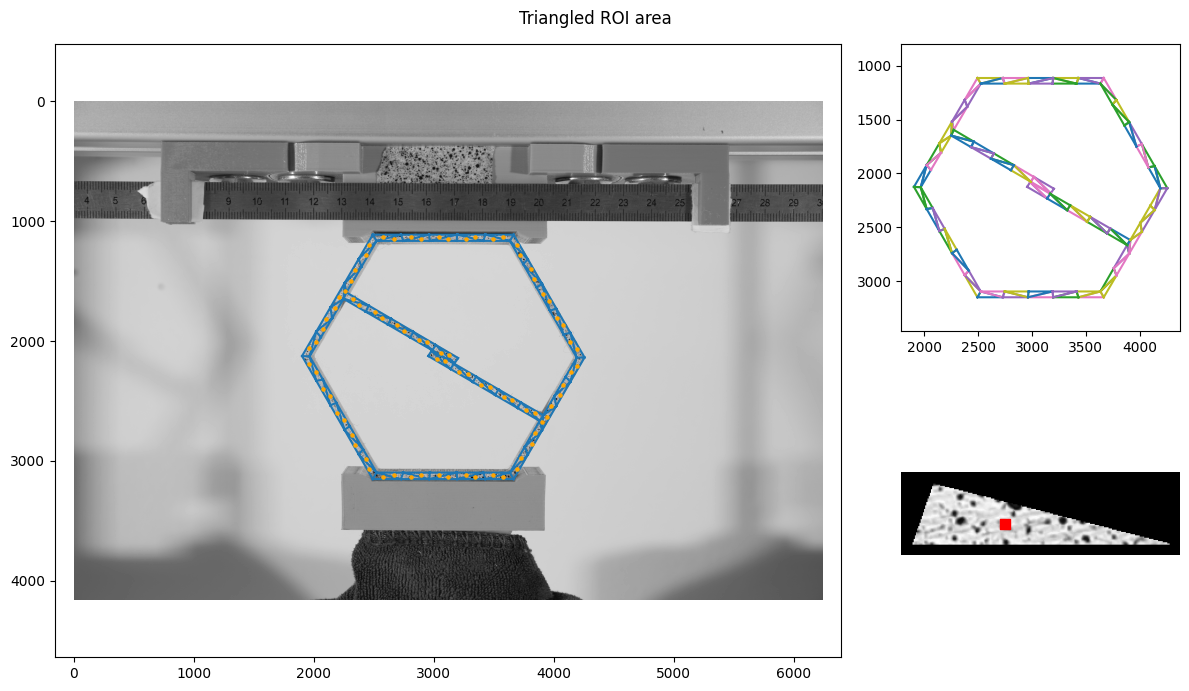


Aktuální proces:  [ 1 / 3 ]	  Fotografie: IMG_0385.JPG

	Spuštění korelace: 	Oblast 1  [1 / 1]
	▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰  100%   [𝘾𝙤𝙢𝙥𝙡𝙚𝙩𝙚𝙙: 12]
	Nalezené oblasti:
		Přesnost: [100 100 100 100 100 100 100 100 100 100 100 100] %

	Chcete použít automatické oříznutí fotografie sledované plochy?
	Zvolena možnost 'Y'

	Chcete zobrazit oříznutou fotografii?
	Zvolena možnost 'N'

	Vytváření hledaných bodů.
		- K výpočtu zvolena metoda SIFT.
	Hledané body vytvořeny.

		Elements: 
			▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰  100%   [𝘾𝙤𝙢𝙥𝙡𝙚𝙩𝙚𝙙: 82]
	Hledání elementů dokončeno.
		Doba vytváření: 34.49 s.

Vyhodnocování výsledků.

	Úspěšně nalezeno  { 82 / 82 }  elementů.

	Počet špatných bodů: 0 
		-     Indexy: [] 
		- Vzdálenost: []

Aktuální proces:  [ 2 / 3 ]	  Fotografie: IMG_0401.JPG

	Spuštění korelace: 	Oblast 1  [1 / 1]
	▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰  100%   [𝘾𝙤𝙢𝙥𝙡𝙚𝙩𝙚𝙙: 12]
	Nalezené oblasti:
		Přesnost: [99 99 99 99 99 99 99 98 99 99 99 99] %

	Vytváření hledaných bodů.
		- K výpočtu zvolena metoda SIFT.
	Hledané bod

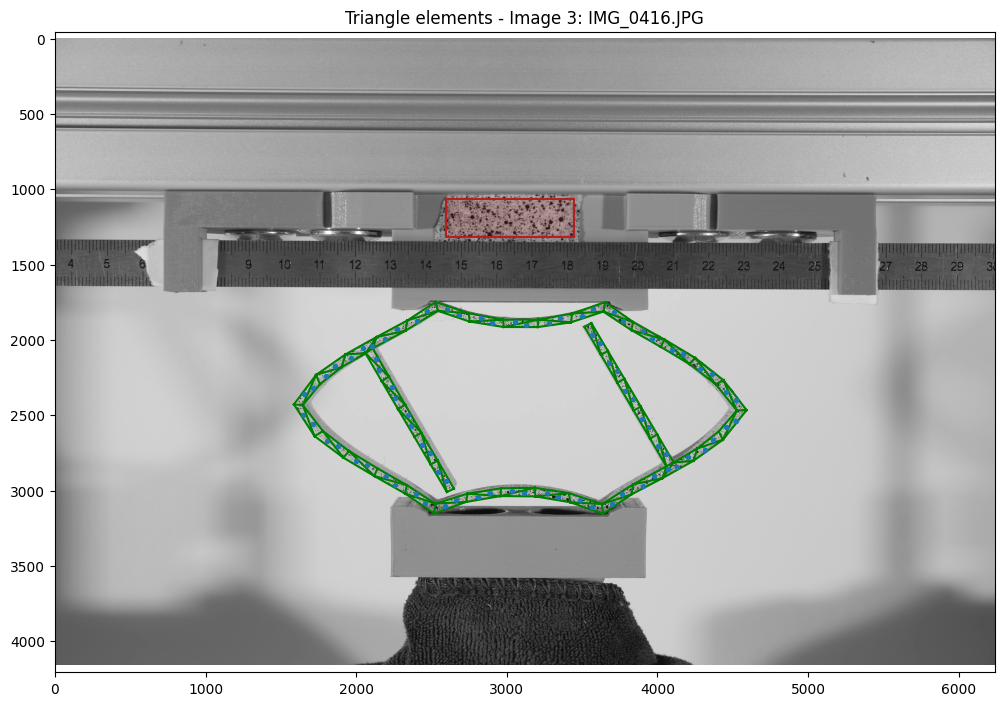


................................................................. 
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Dokončení výpočtu 1. složky ' _test '		[ 1 / 1 ]

Ukončení programu.


In [6]:
import pygmsh

if __name__ == '__main__':
    global folder_measurement, image_files, current_path_to_photos, start, end, loaded_photos, settings
    global gray1, gray2, width, height, proces, graph_count, auto_crop, saved_data_name
    global triangle_vertices_all, triangle_centers_all, triangle_indexes_all, triangle_points_all, \
        correlation_area_points_all, wrong_points_indexes_all, key_points_all, end_marks_all
    global points1, points2, points3, points4, saved_file_exist, current_folder_path, current_image_folder
    global fine_triangle_points_all, fine_mesh_centers_all
    global keypoints1_sift, descriptors1_sift

    # global h5py, zipfile, json, pygmsh

    scale, second_callout = 1, False
    calculations_statuses = {'Correlation': False, 'Rough detection': False,
                             'Fine detection': False, 'Point detection': False}

    ############################################################
    ############################################################
    # ####################### SETTINGS ####################### #

    block_graphs = True  # False = kód poběží dál / True = kód se zastaví

    send_final_message = False

    load_set_points = True
    do_auto_mark = Tee
    mark_points_by_hand = False

    do_just_correlation = False

    main_image_folder = r'C:\Users\matej\PycharmProjects\pythonProject\Python_projects\HEXAGONS\photos'

    folder_measurements = r'C:\Users\matej\PycharmProjects\pythonProject\Python_projects\HEXAGONS\data'

    source_image_type = ['original', 'modified']

    saved_data = 'data_pokus'
    save_calculated_data = False
    load_calculated_data = False

    calculation_methods = "sift"  # all / sift / orb     TODO -- ODSTRANIT: calculation_methods

    do_fine_calculation = False

    size = 250  # !=_ 135 _=!,   250, 100, 85 - min,   (40)
    fine_size = 20  # np.int32(size * 0.1)

    points_limit = 50
    precision = 0.65

    show_final_image = -1  # Kterou fotografii vykreslit

    program_version = 'v0.4.01'

    # Spuštění programu
    print(f"\nSpouštění programu.\n")

    date = get_current_date()

    super_speed = True

    if super_speed:
        block_graphs = False
    main()

In [ ]:
mesh_size=10

print("\nVytvoření podorobných elementů 2.")

fine_triangle_points_all, fine_mesh_centers_all = [], []

def size_up_triangle(coordinates, expansion=1.2):
    triangle_center = tuple(sum(x) / 3 for x in zip(*coordinates))  # Výpočet středu trojúhelníka

    # Posunutí bodů trojúhelníka tak, aby střed byl v počátku souřadnicového systému
    moved_coordinates = [(x - triangle_center[0], y - triangle_center[1]) for x, y in coordinates]

    # Zvětšení trojúhelníka změnou měřítka
    new_coordinates = [(expansion * x, expansion * y) for x, y in moved_coordinates]

    # Vrácení bodů na jejich původní místo (posunutí zpět)
    new_coordinates = [(x + triangle_center[0], y + triangle_center[1]) for x, y in new_coordinates]

    return np.int32(np.round(new_coordinates))  # , triangle_center

def get_affine_matrix(a, b):
    # Výpočet afinní transformační matice mezi body A a B
    # Předpokládá se, že A a B jsou pole se dvěma body každým
    a_extended = np.vstack((a.T, np.ones((1, a.shape[0]))))
    b_extended = np.vstack((b.T, np.ones((1, b.shape[0]))))
    m, _ = np.linalg.lstsq(a_extended.T, b_extended.T, rcond=None)[:2]
    return m.T

def transform_point(transformation_matrix, point):
    # Transformuje bod pomocí transformační matice.

    point_ = np.array(point, dtype=np.float32)  # TODO np.float64 - přesnost ????

    # Přidáme homogenní souřadnici (1) k bodu
    point_homog = np.append(point_, [1])

    # Použijeme afinní transformační matici na bod
    transformed_point_homog = np.dot(transformation_matrix, point_homog)

    # Převedeme homogenní souřadnice zpět na 2D souřadnice (x, y, 1) -> (x, y)
    transformed_point_1 = (transformed_point_homog[0], transformed_point_homog[1])

    # Transformuje bod pomocí transformační matice.

    point_ = np.array(point, dtype=np.float64)  # TODO np.float64 - přesnost ????

    # Přidáme homogenní souřadnici (1) k bodu
    point_homog = np.append(point_, [1])

    # Použijeme afinní transformační matici na bod
    transformed_point_homog = np.dot(transformation_matrix, point_homog)

    # Převedeme homogenní souřadnice zpět na 2D souřadnice (x, y, 1) -> (x, y)
    transformed_point_2 = (transformed_point_homog[0], transformed_point_homog[1])

    transformed__point = ((transformed_point_1[0] + transformed_point_2[0]) / 2,
                          (transformed_point_1[1] + transformed_point_2[1]) / 2)

    return transformed__point

def calculate_fine_mesh():

    for i in range(1, len(image_files)):
        current_photo_fine_tri_points, current_photo_fine_centers = np.empty((0, 3, 2)), np.empty((0, 2))
        for j in range(len(triangle_points_all[0])):

            """transformation_matrix = cv2.getAffineTransform(np.array(triangle_points_all[0][j], dtype=np.float32),
                                                           np.array(triangle_points_all[i][j], dtype=np.float32))"""
            transformation_matrix = get_affine_matrix(triangle_points_all[0][j], triangle_points_all[i][j])

            picture2 = load_photo(i, 0)
            h_, w_ = picture2.shape[:2]
            rotated_image = cv2.warpPerspective(gray1, transformation_matrix, (w_, h_))

            fine_mesh, fine_mesh_centers = divide_image(triangle_points_all[0][j], mesh_size=mesh_size,
                                                        show_graph=False, printout=False)

            fine_triangle_points = fine_mesh.points[fine_mesh.get_cells_type("triangle")][:, :, :2]

            for p in range(len(fine_triangle_points)):
                data = np.zeros((3, 2))
                for k in range(3):
                    data[k] = transform_point(transformation_matrix, fine_triangle_points[p, k])
                    current_photo_fine_tri_points = np.append(current_photo_fine_tri_points, [data], axis=0)

                if True:
                    plt.figure()
                    plt.subplot(131)
                    plt.imshow(gray1)
                    plt.scatter(fine_triangle_points[p, :, 0], fine_triangle_points[p, :, 1], color="blue", marker="+")
                    plt.scatter(triangle_points_all[0][p, :, 0], triangle_points_all[0][p, :, 1], color="red",
                                marker="+")
                    plt.subplot(132)
                    plt.imshow(rotated_image)
                    point_to_transform = (2089.6251772501255, 2006.0266479862269)
                    transformed_point = transform_point(transformation_matrix, point_to_transform)
                    print(point_to_transform)
                    print(transformation_matrix)
                    print(transformed_point)
                    plt.scatter(data[0, 0], data[0, 1], color="red", marker="+")
                    plt.scatter(transformed_point[0], transformed_point[1])
                    plt.subplot(133)
                    plt.imshow(picture2)
                    plt.scatter(triangle_points_all[1][p, :, 0], triangle_points_all[1][p, :, 1], color="red",
                                marker="+")
                    plt.tight_layout()
                    plt.show()

                points = np.int32(np.round(data))
                x1, y1, w1, h1 = cv2.boundingRect(points)
                points_2 = size_up_triangle(coordinates=np.int32(np.round(triangle_points_all[i][j])),
                                            expansion=1.5)
                x2, y2, w2, h2 = cv2.boundingRect(points_2)
                picture1 = gray1[y1:(y1 + h1), x1:(x1 + w1)]
                picture2 = rotated_image[y2:(y2 + h2), x2:(x2 + w2)]
                height1, width1 = picture1.shape[:2]
                height2, width2 = picture2.shape[:2]
                min_x, min_y = np.min(points[:, 0], axis=0), np.min(points[:, 1], axis=0)
                points[:, 0], points[:, 1] = points[:, 0] - min_x, points[:, 1] - min_y

                mask1 = np.zeros((height1, width1), dtype=np.uint8)
                cv2.fillPoly(mask1, [points], 255)
                pic1 = picture1 & mask1

                x_bound, y_bound, w_bound, h_bound = cv2.boundingRect(points)
                relative_points = points - np.array([x_bound, y_bound])

                pic1 = pic1[y_bound:(y_bound + h_bound), x_bound:(x_bound + w_bound)]

                min1, max1 = np.min(pic1), np.max(pic1)
                pic1 = cv2.normalize(pic1, None, min1, max1, cv2.NORM_MINMAX, dtype=cv2.CV_64F)  # 0, 1

                """for x in range(width2 - w_bound):
                    for y in range(height2 - h_bound):
                        mask2 = np.zeros((h_bound, w_bound), dtype=np.uint8)
                        pic2 = picture2[y:y + h_bound, x:x + w_bound]
                        cv2.fillPoly(mask2, [relative_points], 255)
                        pic2 = pic2 & mask2

                        pixel_values_np[y, x] = correlate(pic1, pic2)"""

                pixel_values_np = np.array([
                    [
                        np.linalg.norm(
                            pic1 - cv2.normalize(picture2[y:y + h_bound, x:x + w_bound] & cv2.fillPoly(
                                np.zeros((h_bound, w_bound), dtype=np.uint8), [relative_points], 255), None,
                                                 min1, max1, cv2.NORM_MINMAX, dtype=cv2.CV_64F))
                        for x in range(width2 - w_bound)
                    ]
                    for y in range(height2 - h_bound)
                ])

                min_position = list(np.unravel_index(np.argmin(pixel_values_np), pixel_values_np.shape))
                min_position[0], min_position[1] = min_position[1], min_position[0]
                """print([x1, y1])
                print(min_position)"""

                if True:
                    plt.figure()
                    plt.subplot(141)
                    plt.imshow(picture1)
                    plt.subplot(143)
                    plt.imshow(picture2[min_position[1]:min_position[1] + h_bound,
                               min_position[0]:min_position[0] + w_bound])
                    plt.subplot(144)
                    plt.imshow(picture2)
                    rectangle = plt.Rectangle((min_position[0], min_position[1]), w_bound, h_bound,
                                              edgecolor='red',
                                              facecolor='none')
                    plt.gca().add_patch(rectangle)
                    plt.tight_layout()
                    plt.show()

            transformed_data = cv2.perspectiveTransform(fine_mesh_centers.reshape(-1, 1, 2),
                                                        transformation_matrix).reshape(-1, 2)
            current_photo_fine_centers = np.append(current_photo_fine_centers, transformed_data, axis=0)

    return current_photo_fine_tri_points, current_photo_fine_centers

fine_tr_point_cur, fine_mesh_point_cur = calculate_fine_mesh()
fine_triangle_points_all.extend(fine_tr_point_cur)
fine_mesh_centers_all.extend(fine_mesh_point_cur)

calculations_statuses['Fine detection'] = True

h = -1
plt.figure()
gray_im = load_photo(img_index=h, color_type=0)
plt.imshow(gray_im, cmap='gray')

[plt.gca().add_patch(plt.Polygon(np.array(polygon_coords), edgecolor='b', facecolor='none'))
 for polygon_coords in fine_triangle_points_all[h]]

triangles = triangle_vertices_all[h]
tri_index = triangle_indexes_all[h]
plt.triplot(triangles[:, 0], triangles[:, 1], tri_index, color='green')

"""patches = [Polygon(triangle, closed=True, fill=None, color='royalblue') for triangle in
           fine_triangle_points_all[h]]
for patch in patches:
    plt.gca().add_patch(patch)"""
"""plt.gca().add_patch(patches)"""

"""plt.scatter(fine_mesh_centers_all[h][:, 0], fine_mesh_centers_all[h][:, 1],
            s=2,  # Velikost bodů
            c="r",
            marker='o')  # Znak bodů"""

plt.axis('equal')
plt.tight_layout()

plt.pause(0.5)
plt.show(block=block_graphs)
plt.pause(2)

print("\nJemné prohledávání 2 není.")

